## Config

In [31]:
import os
import json
import numpy as np
import cv2
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from tqdm import tqdm
import matplotlib.patches as patches
import pandas as pd
import seaborn as sns

from collections import Counter
import torch

from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms
from torchvision.models import resnet50
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support, roc_curve, auc
import lime
from IPython.display import HTML, display
import matplotlib.pyplot as plt
%matplotlib inline

import sys
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(parent_dir)
from malaria_dataset import MalariaDataset, detection_collate


In [32]:
root_path = os.path.join('..', 'dataset', 'malaria')
image_path = os.path.join('..','dataset','malaria','images')

train_json_path = os.path.join(root_path, 'training_stratified.json')
test_json_path = os.path.join(root_path, 'test_stratified.json')

models_dir = os.path.join('resnet_models')
results_path = os.path.join(models_dir,'grid_search_results.json')

In [33]:
def plotting_cells_count(training_dataset_json):
    # Loading the JSON
    with open(training_dataset_json, 'r') as f:
        training_metadata = json.load(f)

    # Extracting all object categories into a list
    all_categories = []
    for item in training_metadata:
        for obj in item['objects']:
            all_categories.append(obj['category'])

    # Create DataFrame and count categories
    df = pd.DataFrame(all_categories, columns=['category'])
    category_counts = df['category'].value_counts()

    return category_counts.to_dict()

# Example usage
# train_json_path = r"D:\fyp\fyp\train.json"
counts = plotting_cells_count(train_json_path)
print(counts)
counts2 = plotting_cells_count(test_json_path)
print(counts2)


{'red blood cell': 76165, 'trophozoite': 1416, 'difficult': 430, 'ring': 349, 'schizont': 178, 'gametocyte': 142, 'leukocyte': 82}
{'red blood cell': 6869, 'ring': 173, 'trophozoite': 168, 'leukocyte': 21, 'difficult': 16, 'gametocyte': 14, 'schizont': 12}


In [34]:
print("  Checking the category of the FIRST object for each image in the test set  ")

with open(test_json_path, 'r') as f:
    test_metadata = json.load(f)

for i in range(20): # Look at the first 20 images
    item = test_metadata[i]
    if item['objects']:
        first_object_category = item['objects'][0]['category']
        print(f"Image {i}: The first object is a '{first_object_category}'")
    else:
        print(f"Image {i}: Has no objects.")

--- Checking the category of the FIRST object for each image in the test set ---
Image 0: The first object is a 'red blood cell'
Image 1: The first object is a 'red blood cell'
Image 2: The first object is a 'red blood cell'
Image 3: The first object is a 'red blood cell'
Image 4: The first object is a 'red blood cell'
Image 5: The first object is a 'red blood cell'
Image 6: The first object is a 'red blood cell'
Image 7: The first object is a 'red blood cell'
Image 8: The first object is a 'red blood cell'
Image 9: The first object is a 'red blood cell'
Image 10: The first object is a 'red blood cell'
Image 11: The first object is a 'red blood cell'
Image 12: The first object is a 'red blood cell'
Image 13: The first object is a 'red blood cell'
Image 14: The first object is a 'red blood cell'
Image 15: The first object is a 'red blood cell'
Image 16: The first object is a 'red blood cell'
Image 17: The first object is a 'red blood cell'
Image 18: The first object is a 'red blood cell

In [35]:
# Function to count entries in a JSON file
def count_json_entries(file_path):
    if not os.path.exists(file_path):
        print(f"Error: The file path '{file_path}' does not exist.")
        return 0
    
    with open(file_path, 'r') as f:
        data = json.load(f)
    
    # Assuming the JSON data is a list of entries
    return len(data)

# Count entries in each file
train_count = count_json_entries(train_json_path)
test_count = count_json_entries(test_json_path)

# Print the results
print(f"Number of entries in training.json: {train_count}")
print(f"Number of entries in test.json: {test_count}")

Number of entries in training.json: 1190
Number of entries in test.json: 138


In [36]:

with open(results_path, 'r') as f:
    all_results = json.load(f)

# Convert to a DataFrame for easy analysis
results_df = pd.DataFrame(all_results)

# The 'params' column is a dictionary, let's expand it for better sorting
params_df = pd.json_normalize(results_df['params'])
results_df = pd.concat([results_df.drop('params', axis=1), params_df], axis=1)

# Sort by accuracy to find the best run
results_df = results_df.sort_values(by='best_accuracy', ascending=False).reset_index(drop=True)

print("  Top 5 Performing Models  ")
display(results_df.head())

--- Top 5 Performing Models ---


best_accuracy  training_time_minutes  \
0      94.799054              31.345386   
1      94.799054              81.282563   
2      94.799054              31.805229   
3      94.799054              61.675959   
4      94.799054              31.514957   

                                             history     lr optimizer  \
0  {'train_loss': [18.052621239110042, 16.1267716...  0.001      Adam   
1  {'train_loss': [10.830850525906211, 9.11731752...  0.001      Adam   
2  {'train_loss': [18.24737390718962, 16.40099435...  0.001      Adam   
3  {'train_loss': [10.785903629503752, 8.80878385...  0.001      Adam   
4  {'train_loss': [36.578869367900644, 20.2768850...  0.001       SGD   

   batch_size    sampling  image_size  
0          32        none         128  
1          32        none         224  
2          32  oversample         128  
3          32  oversample         224  
4          32        none         128

## Plotting scores

In [ ]:
def plot_training_history(history, params):
    """
    Plots the training and validation loss and accuracy curves from a history dictionary.
    """
    fig, ax = plt.subplots(1, 2, figsize=(20, 7))
    
    # Create an array for the x-axis (epochs)
    epochs = range(1, len(history['train_loss']) + 1)

    #   Plot 1: Loss vs. Epochs  
    ax[0].plot(epochs, history['train_loss'], label='Train Loss', color='royalblue', marker='o', linestyle='--')
    ax[0].plot(epochs, history['val_loss'], label='Validation Loss', color='darkorange', marker='o')
    ax[0].set_title('Loss Over Epochs', fontsize=16)
    ax[0].set_xlabel('Epoch', fontsize=12)
    ax[0].set_ylabel('Loss', fontsize=12)
    ax[0].legend()
    ax[0].grid(True, which='both', linestyle=':', linewidth=0.5)

    #   Plot 2: Accuracy vs. Epochs  
    ax[1].plot(epochs, history['train_accuracy'], label='Train Accuracy', color='royalblue', marker='s', linestyle='--')
    ax[1].plot(epochs, history['val_accuracy'], label='Validation Accuracy', color='green', marker='s')
    ax[1].set_title('Accuracy Over Epochs', fontsize=16)
    ax[1].set_xlabel('Epoch', fontsize=12)
    ax[1].set_ylabel('Accuracy (%)', fontsize=12)
    ax[1].legend()
    ax[1].grid(True, which='both', linestyle=':', linewidth=0.5)

    # Create a comprehensive title for the entire figure
    param_str = ', '.join([f'{k}={v}' for k, v in params.items()])
    fig.suptitle(f'Training History for Best Model: {param_str}', fontsize=20)
    
    # Adjust layout to prevent title overlap
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

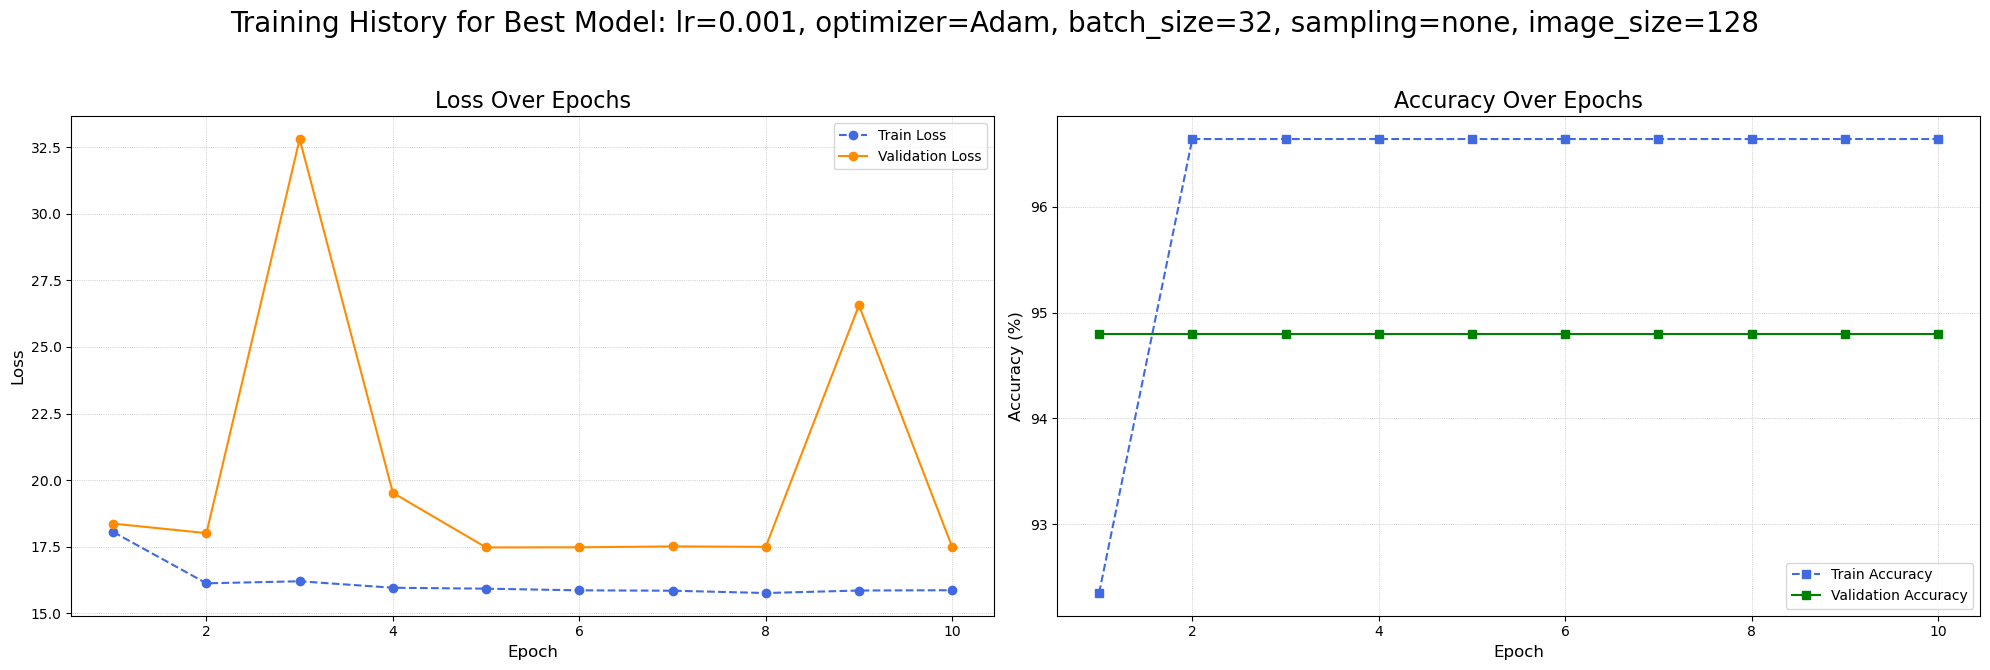

In [38]:
# The history is a string in the JSON, so we need to get it from the original list
best_run_dict = all_results[results_df.index[0]]
best_history = best_run_dict['history']
best_params = best_run_dict['params']

plot_training_history(best_history, best_params) 

In [ ]:
def plot_all_grid_search_results(all_results):
    """
    Plots the validation loss and accuracy for all experiments from a grid search on a single graph.
    """
    fig, ax = plt.subplots(1, 2, figsize=(24, 10))
    
    # Define styles to cycle through to make lines distinguishable
    linestyles = ['-', '--', ':', '-.']
    markers = ['o', 's', 'v', '^', 'D', '<', '>', 'p']
    # Generate a list of distinct colors
    colors = plt.get_cmap('tab20', len(all_results))

    #   Loop through each experiment's results  
    for i, result in enumerate(all_results):
        history = result['history']
        params = result['params']
        
        # Create a short, descriptive label for the legend
        samp_char = 'O' if params.get('sampling', 'none') == 'oversample' else 'N'
        label = f"Run {i+1}: lr={params['lr']}, optim={params['optimizer'][:3]}, size={params['image_size']}, samp={samp_char}"

        epochs = range(1, len(history['val_loss']) + 1)
        
        # Get unique styles for the plot
        style = linestyles[i % len(linestyles)]
        marker = markers[i % len(markers)]
        color = colors(i)

        #   Plot 1: Validation Loss vs. Epochs  
        ax[0].plot(epochs, history['val_loss'], label=label, color=color, linestyle=style, marker=marker, markersize=5)
        
        #   Plot 2: Validation Accuracy vs. Epochs  
        ax[1].plot(epochs, history['val_accuracy'], label=label, color=color, linestyle=style, marker=marker, markersize=5)

    #   Formatting for the Loss Plot  
    ax[0].set_title('Validation Loss Comparison', fontsize=18)
    ax[0].set_xlabel('Epoch', fontsize=14)
    ax[0].set_ylabel('Loss', fontsize=14)
    ax[0].grid(True, which='both', linestyle=':', linewidth=0.7)
    
    #   Formatting for the Accuracy Plot  
    ax[1].set_title('Validation Accuracy Comparison', fontsize=18)
    ax[1].set_xlabel('Epoch', fontsize=14)
    ax[1].set_ylabel('Accuracy (%)', fontsize=14)
    ax[1].grid(True, which='both', linestyle=':', linewidth=0.7)
    
    #   Create a single, shared legend outside the plot area  
    handles, labels = ax[1].get_legend_handles_labels()
    fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1.0, 0.5), fontsize=12, title="Experiments")

    #   Overall Figure Title and Layout Adjustment  
    fig.suptitle('Comparison of All 16 Grid Search Experiments', fontsize=24)
    fig.tight_layout(rect=[0, 0, 0.85, 0.96]) # Adjust layout to make space for the legend and title
    
    plt.show()

Plotting a comparison of all 16 experiments...


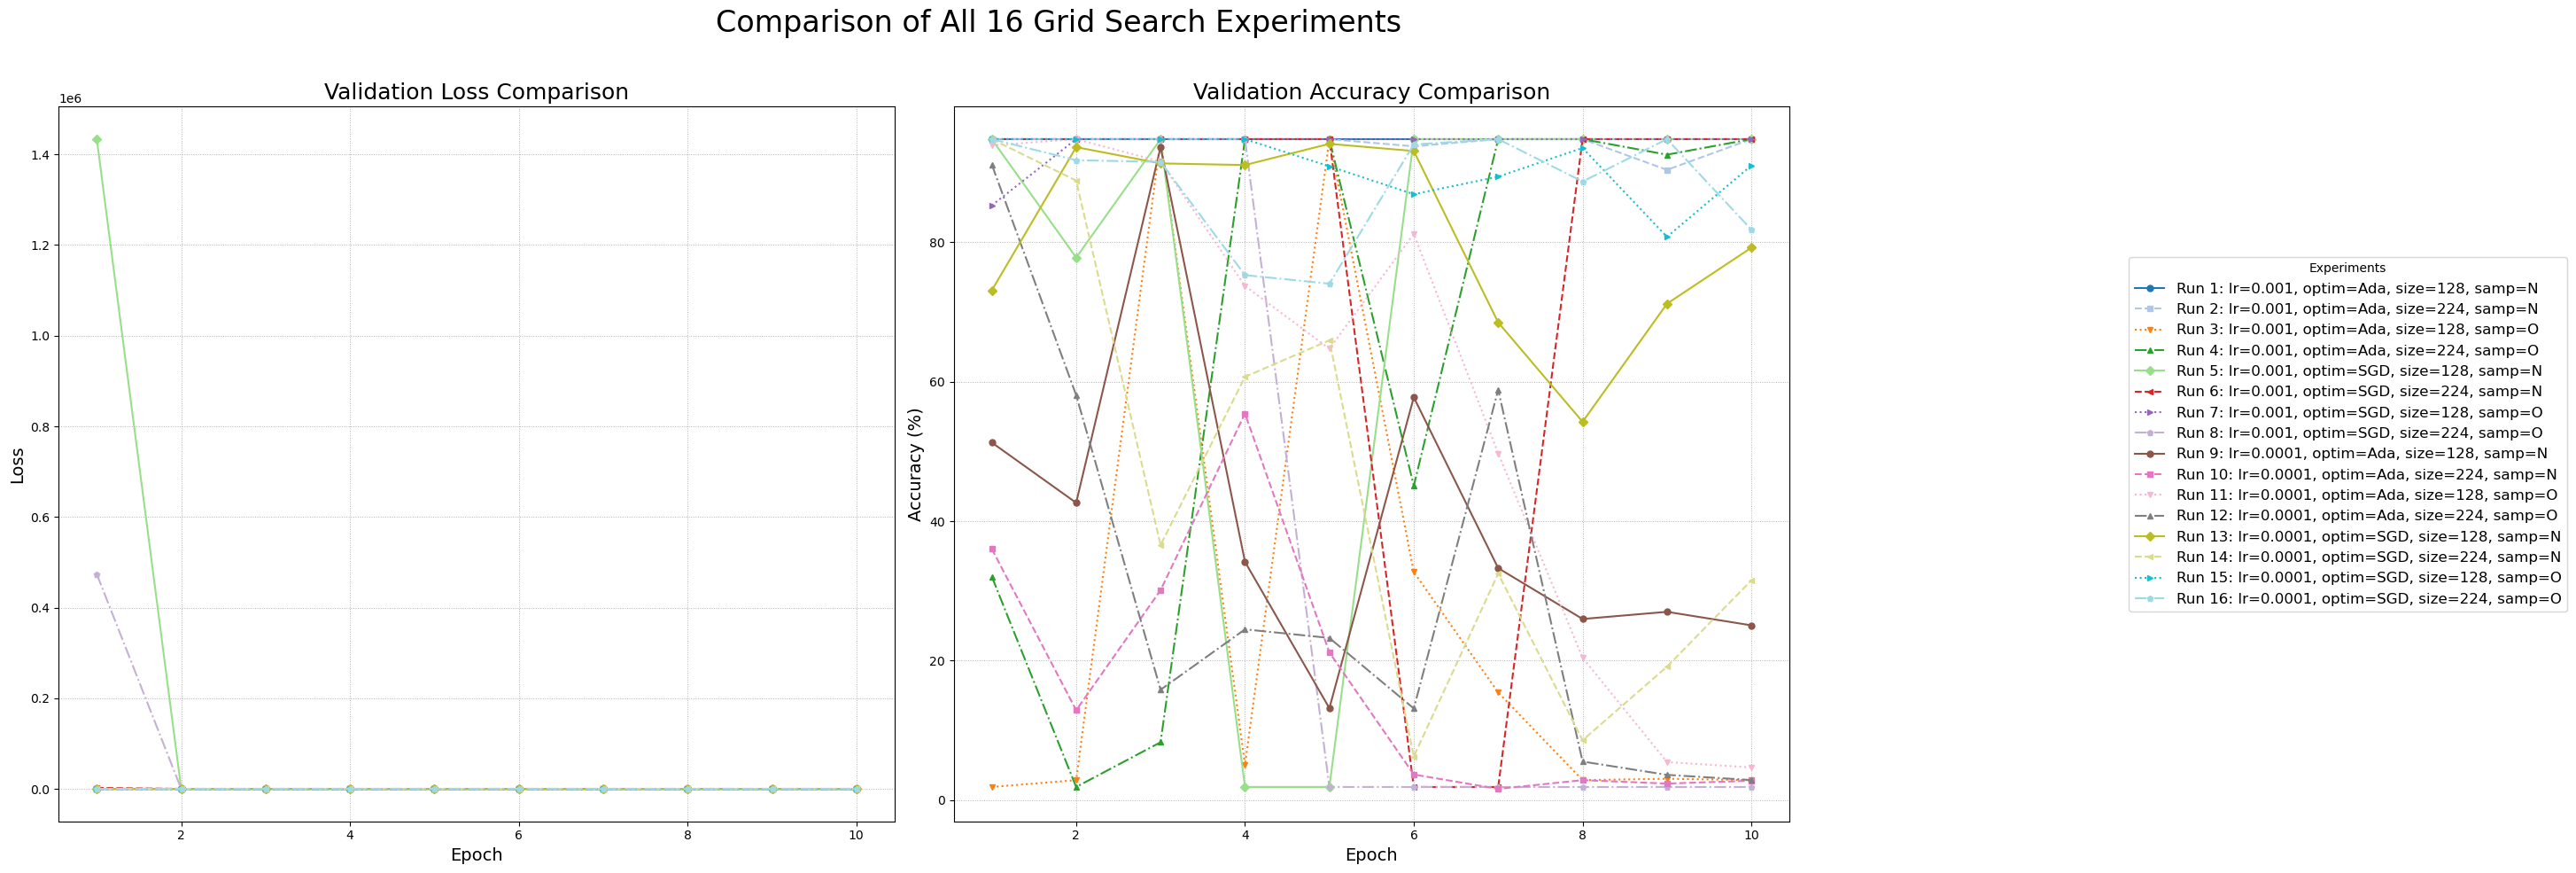

In [40]:
print(f"Plotting a comparison of all {len(all_results)} experiments...")

# Call the new function with your complete results
plot_all_grid_search_results(all_results)

## Model

In [ ]:
class ResNetDetector(nn.Module):
    # Your ResNetDetector class here...
    def __init__(self, num_classes):
        super().__init__()
        self.backbone = resnet50(weights='IMAGENET1K_V1')
        # Replace the final fully connected layer
        num_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Identity() # Remove the original classifier

        self.classifier = nn.Linear(num_features, num_classes)
        self.bbox_head = nn.Linear(num_features, 4)

    def forward(self, x):
        features = self.backbone(x)
        class_scores = self.classifier(features)
        bbox_preds = self.bbox_head(features)
        return class_scores, bbox_preds

In [42]:
def validate_model(model, val_loader, device, category_map, return_preds=False):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    
    # Lists to store ground truth labels and prediction scores for the ROC plot
    all_true = []
    all_scores = []  # Changed from all_preds to all_scores

    with torch.no_grad():
        for images, targets_list in tqdm(val_loader, desc="Validating", leave=False):
            images = images.to(device)
            class_scores, bbox_preds = model(images)

            for i in range(images.size(0)):
                target = targets_list[i]
                target_labels = target['labels'].to(device)
                
                if len(target_labels) == 0: 
                    continue

                if return_preds:
                    # Collect ground truth labels and raw prediction scores
                    all_true.extend(target_labels.cpu().numpy())
                    all_scores.extend(class_scores[i].cpu().numpy())
                
                else:
                    # Your existing logic for validation during training
                    predicted_class = torch.argmax(class_scores[i])
                    target_boxes = target['boxes'].to(device)
                    # NOTE: This line needs image_size. You need to pass it or define it.
                    # Assuming it is a fixed size like 128 from your filename.
                    image_size_val = 128
                    target_boxes_norm = target_boxes / torch.tensor([image_size_val, image_size_val, image_size_val, image_size_val], device=device)
                    
                    loss = margin_loss(class_scores[i].unsqueeze(0), target_labels) + 0.1 * bbox_loss(bbox_preds[i], target_boxes_norm)
                    running_loss += loss.item()

                    correct += (predicted_class == target_labels).sum().item()
                    total += len(target_labels)
    
    if return_preds:
        # Now returns a list of true labels and a list of probability scores
        return all_true, all_scores
    else:
        epoch_loss = running_loss / len(val_loader) if len(val_loader) > 0 else 0
        accuracy = 100 * correct / total if total > 0 else 0
        print(f"Validation Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.2f}%")
        return epoch_loss, accuracy

In [43]:
# Your loss functions and collate_fn here...
def margin_loss(class_scores, targets, margin=0.2):
    one_hot_targets = F.one_hot(targets.long(), num_classes=class_scores.size(-1)).float()
    left = F.relu(margin - class_scores) * one_hot_targets
    right = F.relu(class_scores - (1 - margin)) * (1.0 - one_hot_targets)
    return (left + right).sum(dim=-1).mean()

def bbox_loss(preds, targets):
    if preds.dim() == 1:
        preds = preds.unsqueeze(0)
    num_preds, num_targets = preds.size(0), targets.size(0)
    if num_preds > num_targets:
        padding = torch.zeros((num_preds - num_targets, 4), device=targets.device)
        targets = torch.cat([targets, padding], dim=0)
    elif num_targets > num_preds:
        padding = torch.zeros((num_targets - num_preds, 4), device=preds.device)
        preds = torch.cat([preds, padding], dim=0)
    return F.smooth_l1_loss(preds, targets)

In [ ]:
#   2. Prepare Test DataLoader  
image_size = best_params['image_size']
train_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
test_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_ds_for_map = MalariaDataset(train_json_path, image_path)
category_map = train_ds_for_map.category_map

# Now, create the test dataset using that map
train_ds = MalariaDataset(train_json_path, image_path, transform=train_transform, category_map=category_map, image_size=image_size)
test_ds = MalariaDataset(test_json_path, image_path, transform=test_transform, category_map=category_map, image_size=image_size)

# Finally, create the DataLoader
test_loader = DataLoader(
    test_ds, 
    batch_size=best_params['batch_size'], 
    shuffle=False, 
    collate_fn=detection_collate, # Make sure this function is defined in a cell above
    num_workers=0
)
shuffle = True
sampler = None
# In your run_experiment function or your analysis script...

train_loader = DataLoader(
    train_ds, 
    batch_size=best_params['batch_size'], 
    shuffle=shuffle, 
    sampler=sampler,
    collate_fn=detection_collate,
    num_workers=0
)

val_loader = DataLoader(
    test_ds, 
    batch_size=best_params['batch_size'], 
    shuffle=False, 
    collate_fn=detection_collate,
    num_workers=0 
)

In [45]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

#   Pre-calculation of Class Weights  
# This is efficient because it doesn't change between runs.
with open(train_json_path, 'r') as f:
    train_entries = json.load(f)
temp_ds = MalariaDataset(train_json_path, image_path) # Temp dataset to get map
category_map = temp_ds.category_map
num_classes = len(category_map)
class_names = [name for name, index in sorted(category_map.items(), key=lambda item: item[1])]
labels_for_report = list(range(len(class_names)))
print(f"Found {num_classes} classes: {category_map}")



# #   Setup for tracking results  
# results = []
# grid = list(ParameterGrid(param_grid))

Using device: cpu
Found 7 classes: {'difficult': 0, 'gametocyte': 1, 'leukocyte': 2, 'red blood cell': 3, 'ring': 4, 'schizont': 5, 'trophozoite': 6}


In [46]:
#   Add these lines for debugging  
print(f"Number of samples in test_ds: {len(test_ds)}")
print(f"Number of batches in test_loader: {len(test_loader)}")

# Manually check the first few items from the dataset
# print("\n  Manually inspecting first 3 items from test_ds  ")
# for i in range(3):
#     image_tensor, target = test_ds[i]
#     labels = target['labels']
#     boxes  = target['boxes']
#     print(f"Item {i}: Labels = {labels}, Boxes = {boxes}, Image Shape = {image_tensor.shape}")


Number of samples in test_ds: 138
Number of batches in test_loader: 5


## Saving and plotting the validation summary

In [47]:
#   1. Load the main grid search results JSON  
results_filepath = os.path.join(models_dir, "grid_search_results.json")
with open(results_filepath) as f:
    aggregated_results = json.load(f)

#   2. NEW: Load existing scores to make the script resumable  
summary_csv_path = os.path.join(models_dir, "all_models_scores.csv")
summary_rows = []
completed_params = set()
num_classes = 7
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
try:
    existing_summary_df = pd.read_csv(summary_csv_path)
    # Convert the existing CSV back into a list of dictionaries
    summary_rows = existing_summary_df.to_dict('records')
    
    # Create a set of already completed parameter combinations for fast checking
    for _, row in existing_summary_df.iterrows():
        # Handle NaN for 'sampling' when reading from CSV
        sampling_val = row['sampling'] if pd.notna(row['sampling']) else None
        
        # Create a unique, hashable identifier for each parameter set
        param_tuple = (
            row['lr'], row['optimizer'], row['batch_size'],
            sampling_val, row['image_size']
        )
        completed_params.add(param_tuple)
    print(f"Resuming... Found {len(summary_rows)} existing results in {summary_csv_path}")

except FileNotFoundError:
    print(f"Starting new summary generation. {summary_csv_path} not found.")

#   3. Main Loop to Process Each Model  
for entry in tqdm(aggregated_results, desc="Evaluating models"):
    params = entry["params"]
    
    current_param_tuple = (
        params['lr'], params['optimizer'], params['batch_size'],
        params.get('sampling'), params['image_size']
    )
    if current_param_tuple in completed_params:
        print(f"\nSkipping already evaluated params: {params}")
        continue

    #   Dynamically construct the model path from params  
    # Note: Using .get('sampling', 'none') makes it robust for runs where sampling was not used.
    model_filename = (f"model_lr_{params['lr']}_optim_{params['optimizer']}_"
                      f"sampling_{params.get('sampling', 'none')}_size_{params['image_size']}.pth")
    model_path = os.path.join(models_dir, model_filename)

    #   Load the corresponding model  
    if not os.path.isfile(model_path):
        # This print statement is now much more informative!
        print(f"\nModel file not found, skipping: {model_path}")
        continue
    
    print(f"\nEvaluating model: {model_filename}")
        
    model = ResNetDetector(num_classes=num_classes).to(device)
    # Make sure you are not using weights_only=True if you saved the full checkpoint
    checkpoint = torch.load(model_path, map_location=device) 
    model.load_state_dict(checkpoint["model_state_dict"])
    model.eval()


    #  Prepare DataLoader and get predictions  
    test_loader = DataLoader(test_ds, batch_size=params['batch_size'], shuffle=False, collate_fn=detection_collate)
    y_true, y_pred = validate_model(
        model=model,
        val_loader=test_loader,
        device=device,
        image_size=params['image_size'],
        return_preds=True
        )

    #   Compute classification report  
    report_dict = classification_report(
        y_true, y_pred, target_names=class_names, labels=labels_for_report,
        zero_division=0, output_dict=True
    )
    
    #   Aggregate results into a row  
    row = {
        "lr": params["lr"],
        "optimizer": params["optimizer"],
        "batch_size": params["batch_size"],
        "sampling": params["sampling"],
        "image_size": params["image_size"],
        "train_val_accuracy": entry["best_accuracy"],
        "test_accuracy": report_dict["accuracy"],
        "macro_precision": report_dict["macro avg"]["precision"],
        "macro_recall": report_dict["macro avg"]["recall"],
        "macro_f1": report_dict["macro avg"]["f1-score"],
        "weighted_precision": report_dict["weighted avg"]["precision"],
        "weighted_recall": report_dict["weighted avg"]["recall"],
        "weighted_f1": report_dict["weighted avg"]["f1-score"],
        "training_time_minutes": entry["training_time_minutes"],
    }
    for cls_name in class_names:
        cls_metrics = report_dict.get(cls_name, {})
        row[f"{cls_name}_precision"] = cls_metrics.get("precision")
        row[f"{cls_name}_recall"] = cls_metrics.get("recall")
        row[f"{cls_name}_f1"] = cls_metrics.get("f1-score")
    summary_rows.append(row)

    # Save the updated CSV after each model  
    summary_df = pd.DataFrame(summary_rows)
    summary_df.to_csv(summary_csv_path, index=False)
    print(f"\nUpdated summary saved to {summary_csv_path} with {len(summary_rows)} total results.")

print(f"\n  All models evaluated. Final summary is in {summary_csv_path}  ")

Resuming... Found 16 existing results in resnet_models\all_models_scores.csv


Evaluating models: 100%|██████████| 16/16 [00:00<00:00, 15982.11it/s]


Skipping already evaluated params: {'lr': 0.001, 'optimizer': 'Adam', 'batch_size': 32, 'sampling': 'none', 'image_size': 128}

Skipping already evaluated params: {'lr': 0.001, 'optimizer': 'Adam', 'batch_size': 32, 'sampling': 'none', 'image_size': 224}

Skipping already evaluated params: {'lr': 0.001, 'optimizer': 'Adam', 'batch_size': 32, 'sampling': 'oversample', 'image_size': 128}

Skipping already evaluated params: {'lr': 0.001, 'optimizer': 'Adam', 'batch_size': 32, 'sampling': 'oversample', 'image_size': 224}

Skipping already evaluated params: {'lr': 0.001, 'optimizer': 'SGD', 'batch_size': 32, 'sampling': 'none', 'image_size': 128}

Skipping already evaluated params: {'lr': 0.001, 'optimizer': 'SGD', 'batch_size': 32, 'sampling': 'none', 'image_size': 224}

Skipping already evaluated params: {'lr': 0.001, 'optimizer': 'SGD', 'batch_size': 32, 'sampling': 'oversample', 'image_size': 128}

Skipping already evaluated params: {'lr': 0.001, 'optimizer': 'SGD', 'batch_size': 32, '

In [48]:
#   1. Load the main grid search results JSON  
results_filepath = os.path.join(models_dir, "grid_search_results.json")
with open(results_filepath) as f:
    aggregated_results = json.load(f)

#   2. Load existing scores to make the script resumable  
summary_csv_path = os.path.join(models_dir, "all_models_scores.csv")
summary_rows = []
completed_params = set()
completed_files = set()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

try:
    existing_summary_df = pd.read_csv(summary_csv_path)
    summary_rows = existing_summary_df.to_dict('records')

    # Back-compat: resume either by param tuple OR by saved filename if present
    for _, row in existing_summary_df.iterrows():
        sampling_val = row['sampling'] if pd.notna(row.get('sampling')) else None
        param_tuple = (
            row.get('lr'), row.get('optimizer'), row.get('batch_size'),
            sampling_val, row.get('image_size')
        )
        completed_params.add(param_tuple)

    if 'model_file' in existing_summary_df.columns:
        completed_files = set(
            existing_summary_df['model_file'].dropna().astype(str).tolist()
        )
    elif 'model_path' in existing_summary_df.columns:
        completed_files = set(
            existing_summary_df['model_path'].dropna().map(os.path.basename).astype(str).tolist()
        )

    print(f"Resuming... Found {len(summary_rows)} existing results in {summary_csv_path}")

except FileNotFoundError:
    print(f"Starting new summary generation. {summary_csv_path} not found.")

#   3. Main Loop to Process Each Model  
for entry in tqdm(aggregated_results, desc="Evaluating models"):
    params = entry["params"]

    # Get model file name early so we can show it in logs
    model_path = entry.get("model_path")
    model_file = os.path.basename(model_path) if model_path else None

    #   Skip if already processed (by params OR by filename)  
    current_param_tuple = (
        params['lr'], params['optimizer'], params['batch_size'],
        params.get('sampling'), params['image_size']
    )
    if (current_param_tuple in completed_params) or (model_file and model_file in completed_files):
        print(f"\nSkipping already evaluated model: {model_file or '(unknown file)'}")
        continue

    #   Load the corresponding model  
    if not model_path or not os.path.isfile(model_path):
        print(f"Model file not found: {model_file or model_path} — skipping.")
        continue

    print(f"\nEvaluating: {model_file}")
    model = ResNetDetector(num_classes=num_classes).to(device)
    checkpoint = torch.load(model_path, map_location=device, weights_only=True)
    model.load_state_dict(checkpoint["model_state_dict"])
    model.eval()

    #   Prepare DataLoader and get predictions  
    test_loader = DataLoader(
        test_ds,
        batch_size=params['batch_size'],
        shuffle=False,
        collate_fn=detection_collate
    )
    y_true, y_pred = validate_model(model, test_loader, device, category_map, return_preds=True)

    #   Compute classification report  
    report_dict = classification_report(
        y_true, y_pred, target_names=class_names, labels=labels_for_report,
        zero_division=0, output_dict=True
    )

    #   Aggregate results into a row (now includes filename/path)  
    row = {
        "model_file": model_file,
        "model_path": model_path,
        "lr": params["lr"],
        "optimizer": params["optimizer"],
        "batch_size": params["batch_size"],
        "sampling": params["sampling"],
        "image_size": params["image_size"],
        "train_val_accuracy": entry["best_accuracy"],
        "test_accuracy": report_dict["accuracy"],
        "macro_precision": report_dict["macro avg"]["precision"],
        "macro_recall": report_dict["macro avg"]["recall"],
        "macro_f1": report_dict["macro avg"]["f1-score"],
        "weighted_precision": report_dict["weighted avg"]["precision"],
        "weighted_recall": report_dict["weighted avg"]["recall"],
        "weighted_f1": report_dict["weighted avg"]["f1-score"],
        "training_time_minutes": entry["training_time_minutes"],
    }
    for cls_name in class_names:
        cls_metrics = report_dict.get(cls_name, {})
        row[f"{cls_name}_precision"] = cls_metrics.get("precision")
        row[f"{cls_name}_recall"] = cls_metrics.get("recall")
        row[f"{cls_name}_f1"] = cls_metrics.get("f1-score")

    summary_rows.append(row)

    #   Save the updated CSV after each model  
    summary_df = pd.DataFrame(summary_rows)
    summary_df.to_csv(summary_csv_path, index=False)
    print(f"Saved scores for {model_file} → {summary_csv_path} (total rows: {len(summary_rows)})")

print(f"\n  All models evaluated. Final summary is in {summary_csv_path}  ")

# the path i want to make model_lr_0.001_optim_SGD_sampling_oversample_size_128.pth


Resuming... Found 16 existing results in resnet_models\all_models_scores.csv


Evaluating models: 100%|██████████| 16/16 [00:00<00:00, 15989.72it/s]


Skipping already evaluated model: (unknown file)

Skipping already evaluated model: (unknown file)

Skipping already evaluated model: (unknown file)

Skipping already evaluated model: (unknown file)

Skipping already evaluated model: (unknown file)

Skipping already evaluated model: (unknown file)

Skipping already evaluated model: (unknown file)

Skipping already evaluated model: (unknown file)

Skipping already evaluated model: (unknown file)

Skipping already evaluated model: (unknown file)

Skipping already evaluated model: (unknown file)

Skipping already evaluated model: (unknown file)

Skipping already evaluated model: (unknown file)

Skipping already evaluated model: (unknown file)

Skipping already evaluated model: (unknown file)

Skipping already evaluated model: (unknown file)

--- All models evaluated. Final summary is in resnet_models\all_models_scores.csv ---


In [49]:
summary_csv_path = os.path.join(models_dir, "all_models_scores.csv")
summary_df = pd.read_csv(summary_csv_path)

class_columns = [f"{cls}_{metric}" for cls in class_names for metric in ("precision", "recall", "f1")]

# Colour map that shades higher values more intensely
styled_df = summary_df.style.background_gradient(
    subset=class_columns,
    cmap="Blues",
    vmin=0, vmax=1
).format("{:.3f}", subset=class_columns)
display(styled_df)


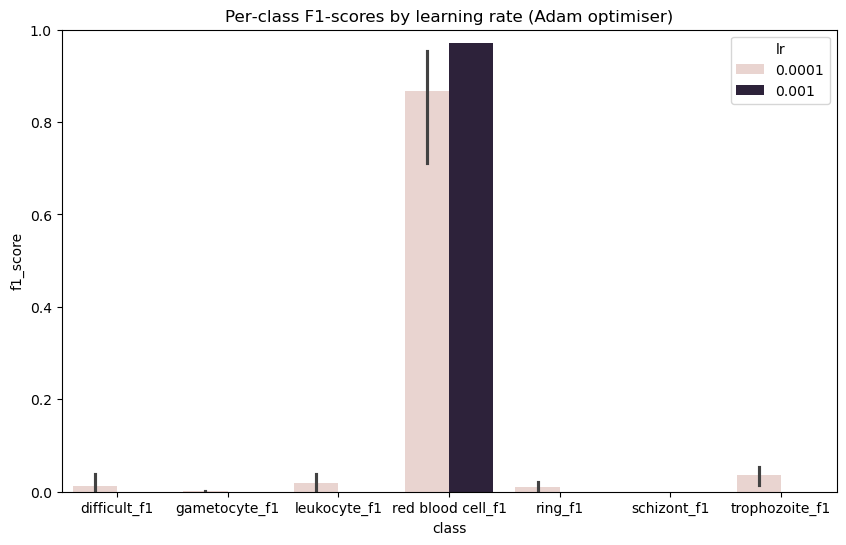

In [50]:
# Filter to a subset if there are many models
plot_df = summary_df[summary_df["optimizer"] == "Adam"]

# Melt the per-class F1 columns into long format
f1_cols = [f"{cls}_f1" for cls in class_names]
melted = plot_df.melt(
    id_vars=["lr", "batch_size", "sampling", "image_size"],
    value_vars=f1_cols,
    var_name="class",
    value_name="f1_score"
)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=melted,
    x="class",
    y="f1_score",
    hue="lr"
)
plt.title("Per‑class F1‑scores by learning rate (Adam optimiser)")
plt.ylim(0, 1)
plt.show()


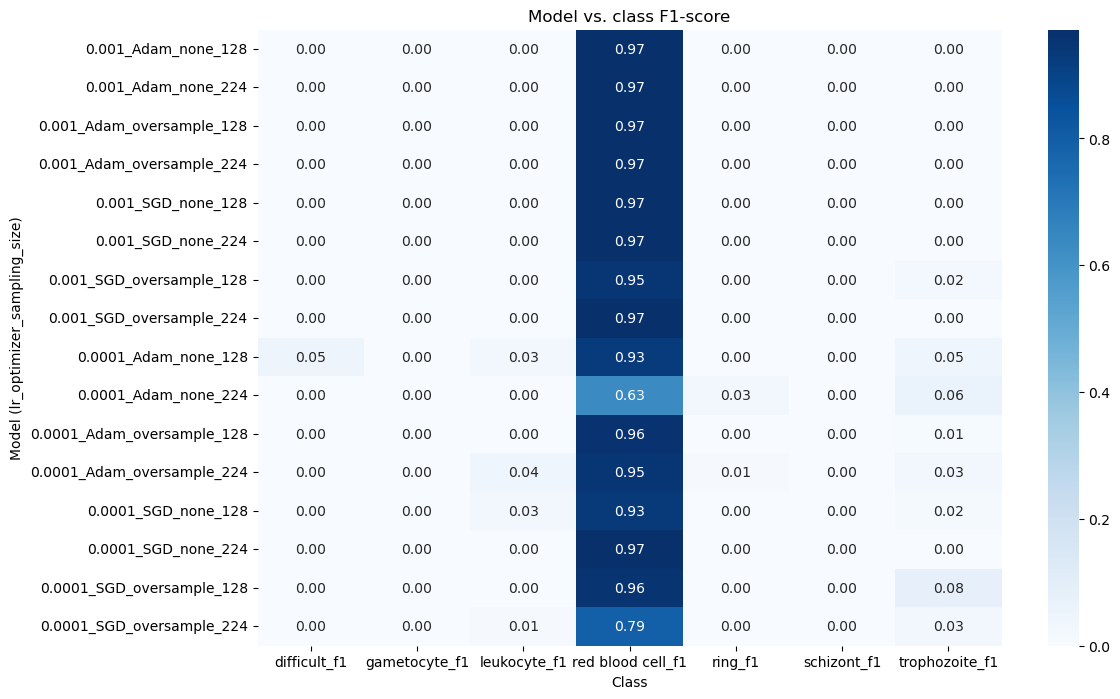

In [51]:
# Build a pivot table: rows = models, columns = class F1-scores
row_index = (summary_df["lr"].astype(str) + "_" +
             summary_df["optimizer"] + "_" +
             summary_df["sampling"] + "_" +
             summary_df["image_size"].astype(str))
heatmap_df = summary_df.set_index(row_index)[f1_cols]

plt.figure(figsize=(12, len(heatmap_df)/2))
sns.heatmap(heatmap_df, annot=True, fmt=".2f", cmap="Blues")
plt.title("Model vs. class F1-score")
plt.xlabel("Class")
plt.ylabel("Model (lr_optimizer_sampling_size)")
plt.show()


### Model prediction

In [52]:
# Create a single dictionary to hold all ground truth entries
all_entries_map = {}

# Populate the map from the training dataset
for entry in train_ds.entries:
    filename = os.path.basename(entry['image']['pathname'])
    all_entries_map[filename] = entry

# Add/overwrite with entries from the test dataset
for entry in test_ds.entries:
    filename = os.path.basename(entry['image']['pathname'])
    all_entries_map[filename] = entry

print(f"Created a lookup map with {len(all_entries_map)} total unique image entries.")

Created a lookup map with 1328 total unique image entries.


## Gradcam

In [55]:
# Create a single dictionary to hold all ground truth entries
all_entries_map = {}

# Populate the map from the training dataset
for entry in train_ds.entries:
    filename = os.path.basename(entry['image']['pathname'])
    all_entries_map[filename] = entry

# Add/overwrite with entries from the test dataset
for entry in test_ds.entries:
    filename = os.path.basename(entry['image']['pathname'])
    all_entries_map[filename] = entry

print(f"Created a lookup map with {len(all_entries_map)} total unique image entries.")

Created a lookup map with 1328 total unique image entries.


In [ ]:
class GradCAM:
    """
    A robust Grad-CAM class that properly manages and removes hooks.
    """
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        
        # Store hook handles to be able to remove them later
        self.handles = []
        self._register_hooks()

    def _capture_activations(self, module, input, output):
        self.activations = output.detach()

    def _capture_gradients(self, module, grad_in, grad_out):
        self.gradients = grad_out[0].detach()

    def _register_hooks(self):
        # Register hooks and store their handles
        handle_forward = self.target_layer.register_forward_hook(self._capture_activations)
        handle_backward = self.target_layer.register_full_backward_hook(self._capture_gradients)
        self.handles.extend([handle_forward, handle_backward])

    def remove_hooks(self):
        # Use the stored handles to remove the hooks
        for handle in self.handles:
            handle.remove()

    def generate_heatmap(self, model_output, class_idx):
        if class_idx is None:
            class_idx = model_output.argmax(dim=1)
        
        self.model.zero_grad()
        # Use .sum() for multi-label or change logic for single label
        model_output[0, class_idx].backward(retain_graph=True)
        
        pooled_gradients = torch.mean(self.gradients, dim=[0, 2, 3])
        
        # Make a copy to avoid in-place modification issues
        activations = self.activations.clone()
        for i in range(activations.shape[1]):
            activations[:, i, :, :] *= pooled_gradients[i]
            
        heatmap = torch.mean(activations, dim=1).squeeze().cpu()
        heatmap = F.relu(heatmap)
        heatmap /= (torch.max(heatmap) + 1e-8)
        
        return heatmap.numpy()

In [ ]:
def visualize_prediction_with_gradcam(
    model, image_path, all_entries_map, device, class_names,
    model_name="", image_size=224, threshold=0.5
):
    """
    Performs a prediction on a single image, prints a summary of
    predicted vs. ground truth labels and infection status, and displays
    both the Grad-CAM heatmap and the ground-truth bounding boxes.
    """
    # Define which classes indicate infection
    parasite_classes = {"gametocyte", "trophozoite", "schizont", "ring"}

    target_layer = model.backbone.layer4
    grad_cam = GradCAM(model, target_layer)

    try:
        if model_name:
            print(f"\n### Model: {model_name} ###")
        print(f"  Processing image: {os.path.basename(image_path)}  ")
        # Define which classes indicate infection
        print(f"  Processing image: {os.path.basename(image_path)}  ")
        image_pil = Image.open(image_path).convert("RGB")
        transform = transforms.Compose([
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
        image_tensor = transform(image_pil).unsqueeze(0).to(device)

        model.eval()
        output = model(image_tensor)  # keep gradients enabled
        class_scores = output[0] if isinstance(output, tuple) else output

        # Aggregate over boxes if necessary
        if class_scores.dim() == 3:
            # sum scores over the box dimension -> shape (1, n_classes)
            class_scores_agg = class_scores.sum(dim=1)
        else:
            class_scores_agg = class_scores

        # Convert to probabilities and determine predicted labels
        probabilities = torch.sigmoid(class_scores_agg[0])
        predicted_indices = (probabilities >= threshold).nonzero(as_tuple=True)[0]
        predicted_labels = {class_names[i] for i in predicted_indices}

        # Sort probabilities for a readable breakdown
        all_scores = sorted(
            [(class_names[i], probabilities[i].item()) for i in range(len(class_names))],
            key=lambda x: x[1],
            reverse=True,
        )
        print("\n  Prediction Breakdown  ")
        for cname, score in all_scores:
            print(f"  - {cname:<15}: {score*100:.2f}%")

        # Ground-truth extraction
        filename = os.path.basename(image_path)
        gt_entry = all_entries_map.get(filename)
        gt_labels = set()
        if gt_entry and gt_entry.get("objects"):
            gt_labels = {obj["category"] for obj in gt_entry["objects"]}
        print("\n  Ground Truth Breakdown  ")
        if gt_entry and gt_entry.get("objects"):
            freqs = Counter(obj["category"] for obj in gt_entry["objects"])
            for cname, cnt in freqs.most_common():
                print(f"  - {cname:<15}: {cnt}")
        else:
            print("  - No ground truth objects listed for this image.")

        # Infection status
        predicted_status = "Infected" if predicted_labels & parasite_classes else "Not Infected"
        actual_status = "Infected" if gt_labels & parasite_classes else "Not Infected"
        diagnosis_correct = predicted_status == actual_status

        print("\n  Final Diagnosis  ")
        print(f"Model Diagnosis: {predicted_status} | Actual Status: {actual_status}")

        # Comparison of labels
        true_positives = predicted_labels & gt_labels
        false_positives = predicted_labels - gt_labels
        false_negatives = gt_labels - predicted_labels
        print("\n  Prediction Summary  ")
        print(f"Correctly Predicted: {', '.join(true_positives) if true_positives else 'None'}")
        print(f"Missed: {', '.join(false_negatives) if false_negatives else 'None'}")
        print(f"Incorrectly Predicted: {', '.join(false_positives) if false_positives else 'None'}")

        # Grad-CAM for the top class
        top_class_idx = probabilities.argmax().item()
        top_class_name = class_names[top_class_idx]
        print(f"\nGenerating Grad-CAM for the top prediction: '{top_class_name}'")
        heatmap = grad_cam.generate_heatmap(class_scores_agg, class_idx=top_class_idx)

        # Prepare heatmap overlay
        heatmap_resized = cv2.resize(heatmap, (image_pil.width, image_pil.height))
        heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
        heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB)
        image_np = np.array(image_pil)
        overlay_img = cv2.addWeighted(image_np, 0.6, heatmap_colored, 0.4, 0)

        # When plotting, you can set a suptitle or include model_name in the subplot title
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))
        # Left-hand title includes the model name and the top class
        left_title = f"{model_name}\nGrad-CAM: '{top_class_name}' ({probabilities[top_class_idx]*100:.2f}%)"
        ax1.imshow(overlay_img)
        ax1.set_title(left_title, color="green" if diagnosis_correct else "red")
        ax1.axis("off")
        if predicted_labels:
            ax1.text(0.02, 0.98, "Predicted Classes:\n" + "\n".join(f"- {c}" for c in sorted(predicted_labels)),
                     transform=ax1.transAxes, fontsize=10, va="top",
                     bbox=dict(boxstyle="round", facecolor="limegreen", alpha=0.6))

        # Right: Ground truth boxes and labels
        ax2.imshow(image_np)
        ax2.set_title(f"Ground Truth: {actual_status}")
        ax2.axis("off")
        if gt_entry and gt_entry.get("objects"):
            for obj in gt_entry["objects"]:
                bb = obj["bounding_box"]
                rect = patches.Rectangle(
                    (bb["minimum"]["c"], bb["minimum"]["r"]),
                    bb["maximum"]["c"] - bb["minimum"]["c"],
                    bb["maximum"]["r"] - bb["minimum"]["r"],
                    linewidth=2, edgecolor="gold", facecolor="none"
                )
                ax2.add_patch(rect)
                ax2.text(bb["minimum"]["c"], bb["minimum"]["r"] - 10,
                         obj["category"], color="black", fontsize=8,
                         bbox=dict(facecolor="gold", alpha=0.7, edgecolor="none"))

        plt.tight_layout()
        plt.show()

    finally:
        grad_cam.remove_hooks()


C:\Users\shera\AppData\Local\Temp\ipykernel_21348\781497846.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)



### Model: model_lr_0.0001_optim_ADAM_sampling_none_size_224.pth ###
--- Processing image: 0a747cb3-c720-4572-a661-ab5670a5c42e.png ---
--- Processing image: 0a747cb3-c720-4572-a661-ab5670a5c42e.png ---

--- Prediction Breakdown ---
  - red blood cell : 65.59%
  - ring           : 64.94%
  - trophozoite    : 58.85%
  - schizont       : 55.90%
  - difficult      : 55.28%
  - leukocyte      : 50.83%
  - gametocyte     : 49.70%

--- Ground Truth Breakdown ---
  - red blood cell : 53
  - difficult      : 1

--- Final Diagnosis ---
Model Diagnosis: Infected | Actual Status: Not Infected

--- Prediction Summary ---
Correctly Predicted: red blood cell
Missed: difficult
Incorrectly Predicted: ring

Generating Grad-CAM for the top prediction: 'red blood cell'


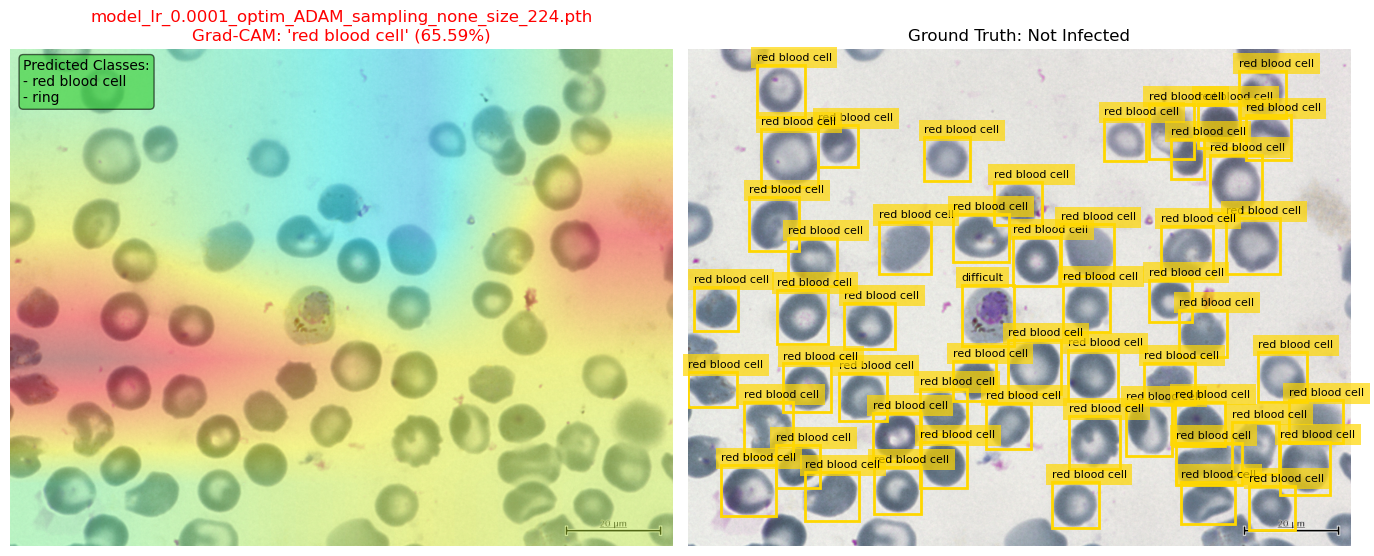

In [80]:
my_image_path = os.path.join(image_path, '0a747cb3-c720-4572-a661-ab5670a5c42e.png')

# for entry in aggregated_results:
for i in range(1):
    params = entry["params"]
    sampling_str = params.get("sampling") or "none"
    # model_file = (
    #     f"model_lr_{params['lr']}_optim_{params['optimizer']}_"
    #     f"sampling_{sampling_str}_size_{params['image_size']}.pth"
    # )
    
    # Analysing the best model
    model_file = (
        f"model_lr_0.0001_optim_ADAM_"
        f"sampling_none_size_224.pth"
    )
    model_path = os.path.join(models_dir, model_file)
    if not os.path.isfile(model_path):
        continue

    model = ResNetDetector(num_classes=num_classes).to(device)
    checkpoint = torch.load(model_path, map_location=device)
    model.load_state_dict(checkpoint["model_state_dict"])
    model.eval()

    visualize_prediction_with_gradcam(
        model=model,
        image_path=my_image_path,
        all_entries_map=all_entries_map,
        device=device,
        class_names=class_names,
        model_name=model_file,        # pass the filename as the model label
        image_size=params["image_size"],
        threshold=0.6
    )


In [ ]:
from sklearn.preprocessing import label_binarize

def validate_model(model, val_loader, device, image_size, num_classes):
    """
    Validates the model on the given loader.
    
    Returns:
        y_true: Ground truth labels.
        y_pred: Final predicted labels (after applying a 0.5 threshold).
        y_scores: Raw probability scores for each class.
    """
    model.eval()
    
    all_true = []
    all_preds = []
    all_scores = []

    with torch.no_grad():
        for images, targets_list in tqdm(val_loader, desc="Validating", leave=False):
            images = images.to(device)
            # The model output is (class_scores, bbox_preds)
            class_scores, _ = model(images)

            for i in range(images.size(0)):
                target = targets_list[i]
                target_labels = target['labels'] # Keep on CPU for this part
                
                if len(target_labels) == 0: 
                    continue

                #   Get Scores and Predictions  
                # Use sigmoid to get independent probabilities for each class
                probabilities = torch.sigmoid(class_scores[i])
                
                # Get final predictions based on a 0.5 threshold
                predicted_labels = (probabilities > 0.5).int()

                # For multi-label, we need to format the ground truth
                # Create a multi-hot encoded vector for the true labels
                true_multi_hot = torch.zeros(num_classes)
                true_multi_hot[target_labels.unique()] = 1

                # Store results for each image
                all_true.append(true_multi_hot.numpy())
                all_preds.append(predicted_labels.cpu().numpy())
                all_scores.append(probabilities.cpu().numpy())
    
    # Convert lists of arrays into single numpy arrays
    y_true = np.array(all_true)
    y_pred = np.array(all_preds)
    y_scores = np.array(all_scores)
    
    return y_true, y_pred, y_scores

In [ ]:

def plot_roc_curves(y_true, y_scores, params, class_names):
    """
    Displays a plot of ROC curves for each class and returns the AUC scores.
    """
    auc_scores = {} 
    
    plt.figure(figsize=(12, 10))

    # Calculate and plot ROC curve for each class
    for i, class_name in enumerate(class_names):
        if len(np.unique(y_true[:, i])) > 1:
            fpr, tpr, _ = roc_curve(y_true[:, i], y_scores[:, i])
            roc_auc = auc(fpr, tpr)
            auc_scores[class_name] = roc_auc # Store the AUC score
            plt.plot(fpr, tpr, lw=2, label=f'{class_name} (AUC = {roc_auc:.2f})')
        else:
            print(f"Skipping ROC plot for {class_name}: only one class present.")

    # Calculate Macro Average AUC after the loop
    if auc_scores: # Check if dictionary is not empty
        macro_avg_auc = np.mean(list(auc_scores.values()))
        auc_scores['macro_avg_auc'] = macro_avg_auc
        print(f"Macro Average AUC: {macro_avg_auc:.4f}")
    
    #   Plot formatting (no changes here)  
    plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Guess')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    title = (f"ROC Curves for Model\n"
             f"LR: {params['lr']}, Optimizer: {params['optimizer']}, Sampling: {params.get('sampling', 'none')}, Size: {params['image_size']}")
    plt.title(title, fontsize=16)
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    return auc_scores

Generating ROC Curves:   0%|          | 0/16 [00:00<?, ?it/s]C:\Users\shera\AppData\Local\Temp\ipykernel_21348\1472863007.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


Skipping ROC plot for red blood cell: only one class present.
Macro Average AUC: 0.5788


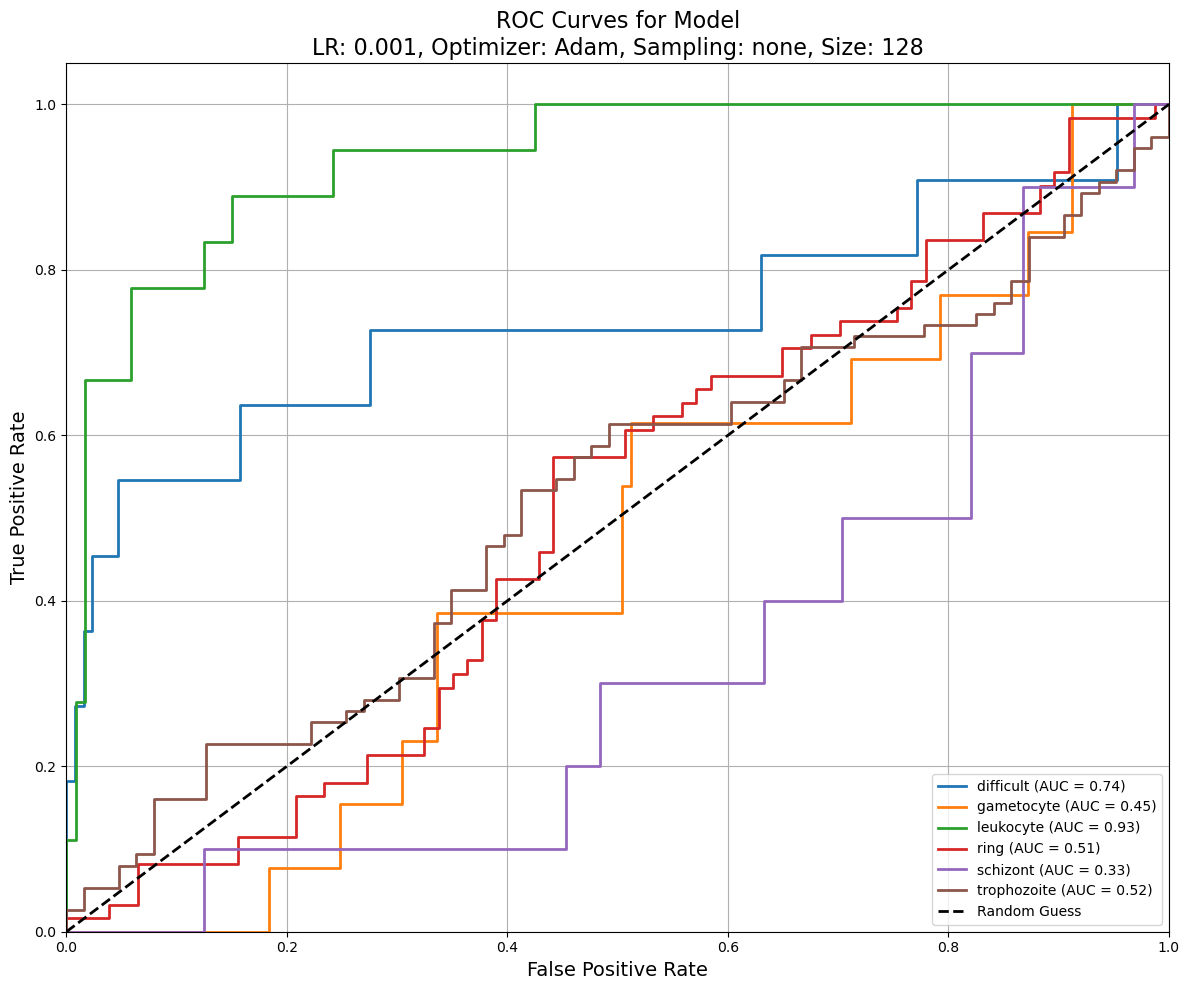

Skipping ROC plot for red blood cell: only one class present.
Macro Average AUC: 0.5788


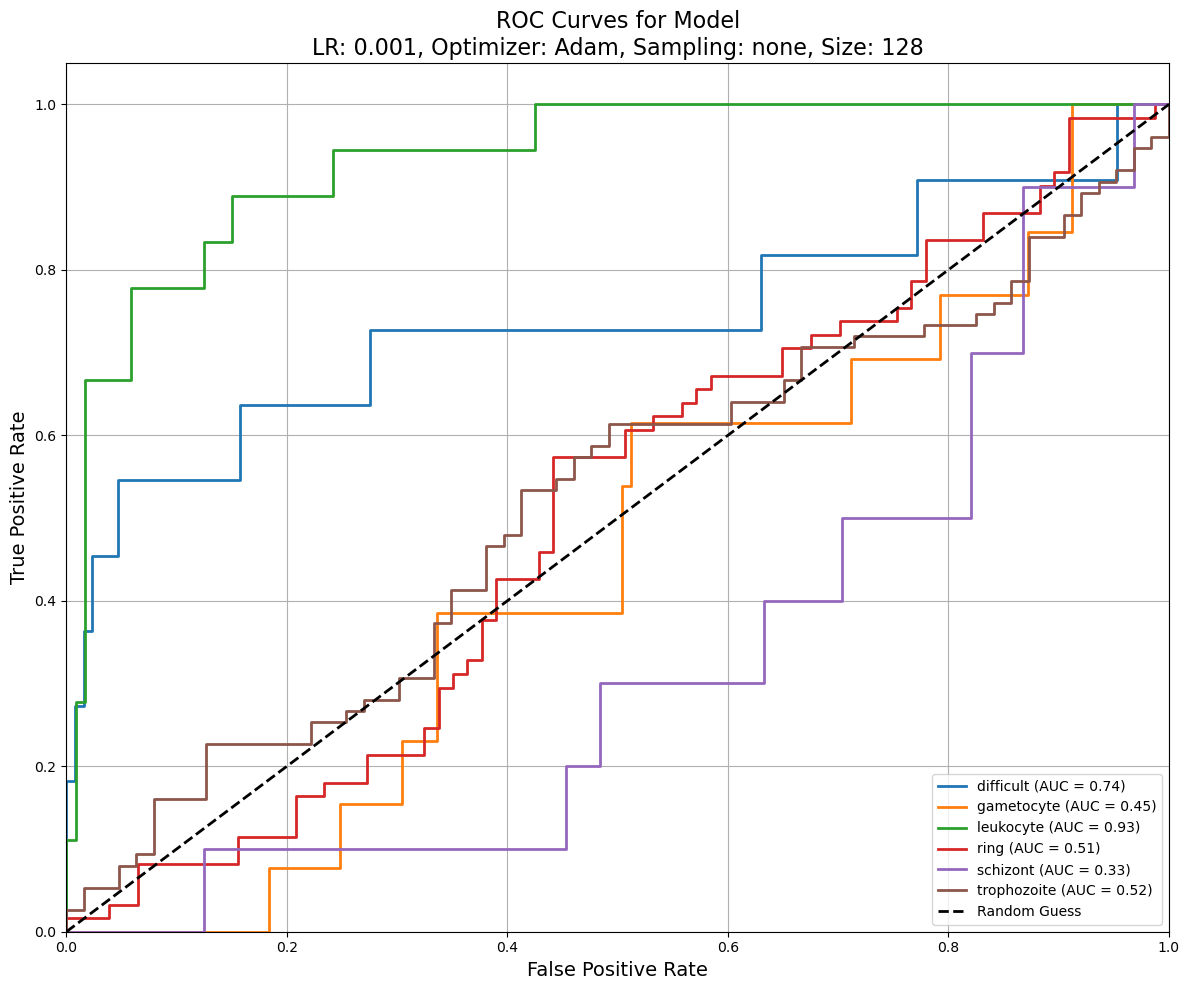

Generating ROC Curves:   6%|▋         | 1/16 [00:19<04:48, 19.21s/it]C:\Users\shera\AppData\Local\Temp\ipykernel_21348\1472863007.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental f

Skipping ROC plot for red blood cell: only one class present.
Macro Average AUC: 0.4339


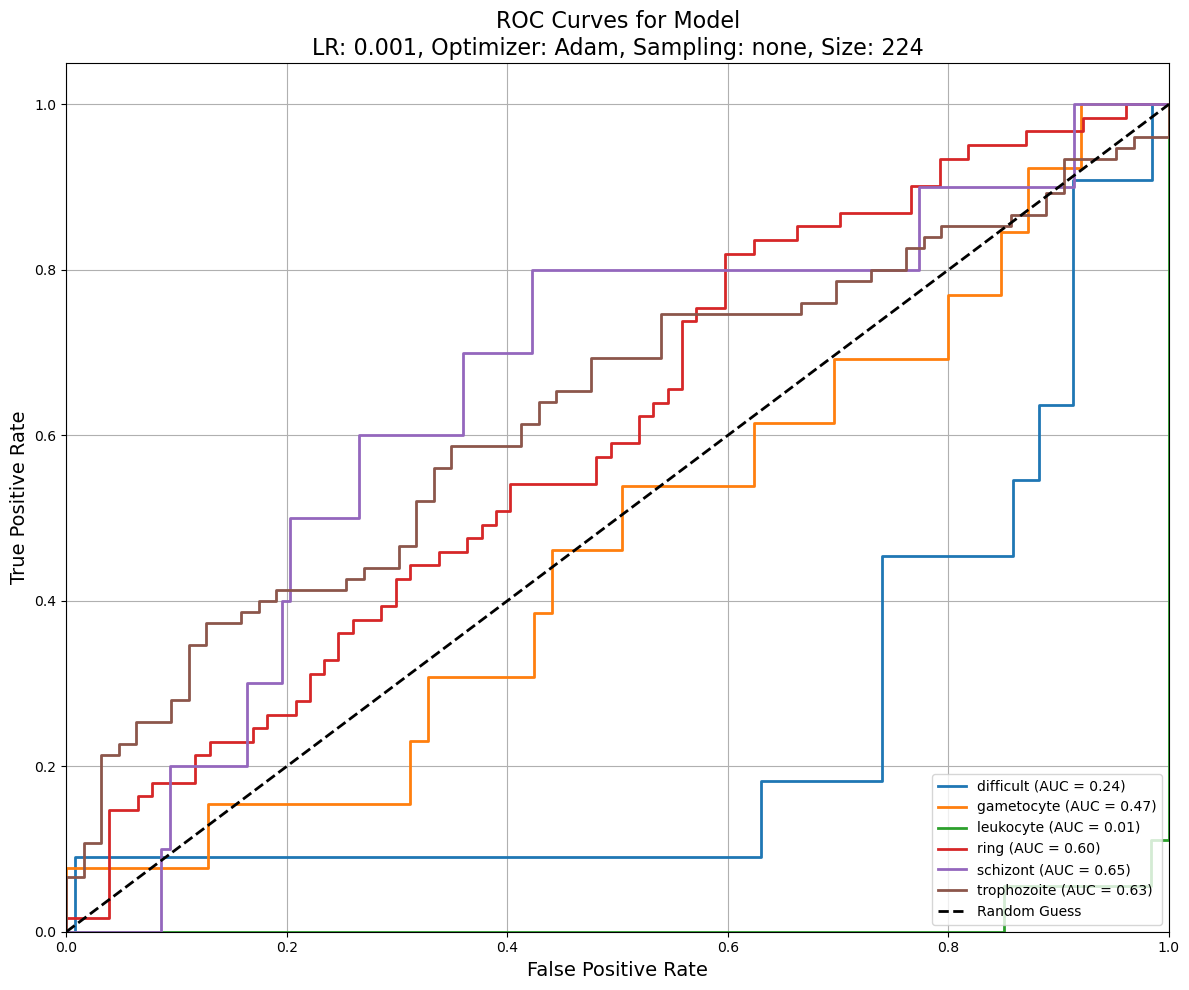

Skipping ROC plot for red blood cell: only one class present.
Macro Average AUC: 0.4339


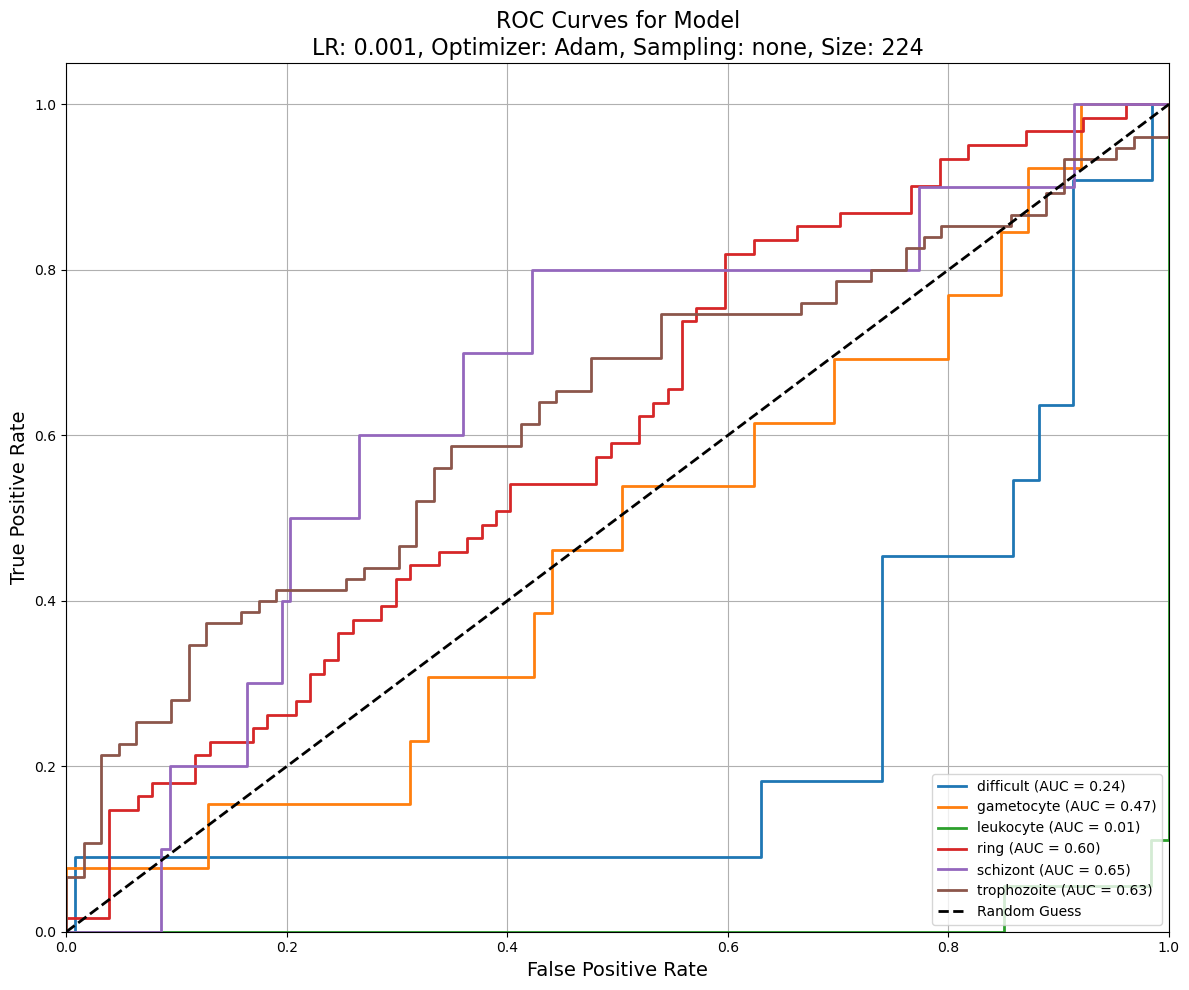

Generating ROC Curves:  12%|█▎        | 2/16 [00:36<04:10, 17.90s/it]C:\Users\shera\AppData\Local\Temp\ipykernel_21348\1472863007.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental f

Skipping ROC plot for red blood cell: only one class present.
Macro Average AUC: 0.4331


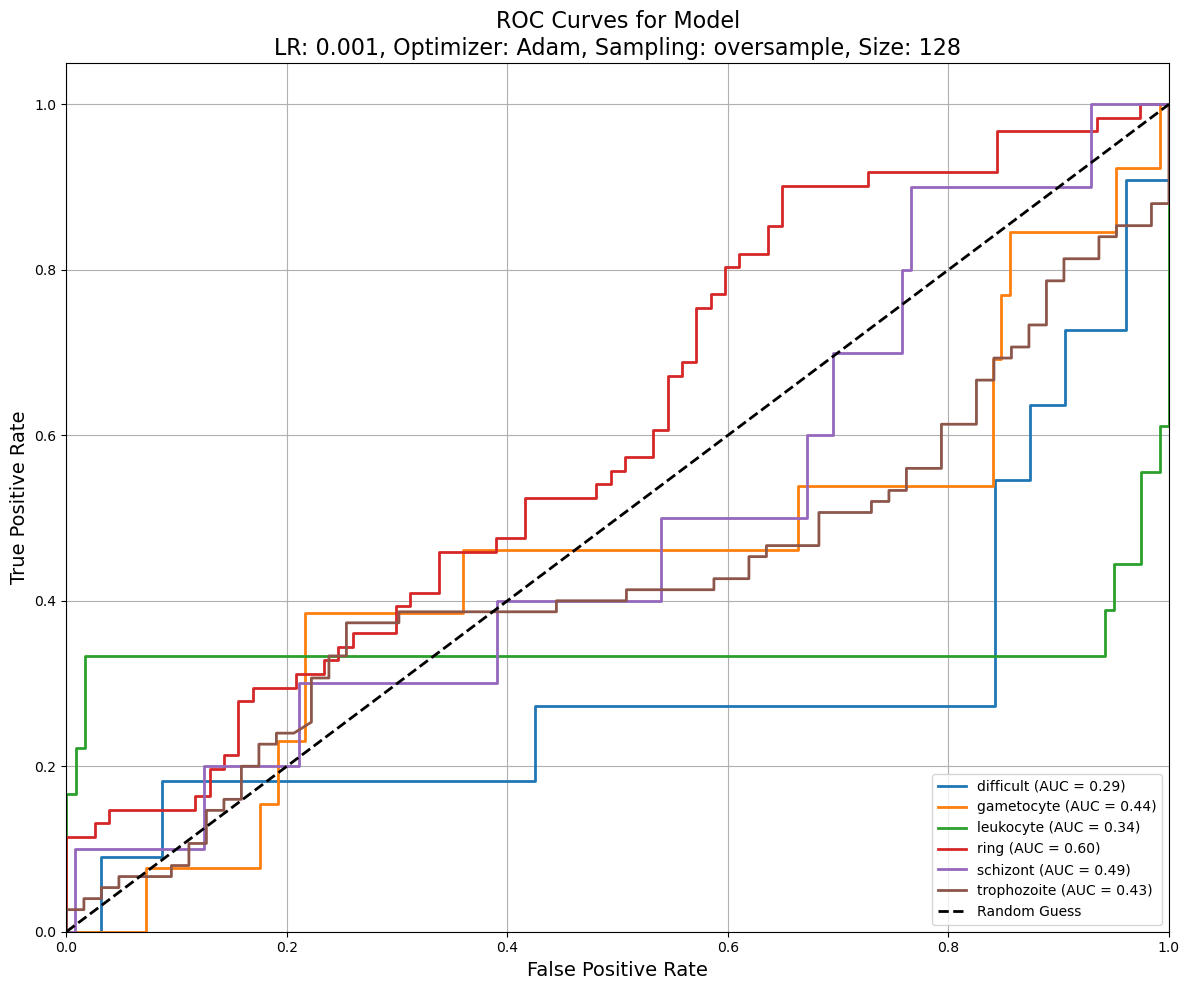

Skipping ROC plot for red blood cell: only one class present.
Macro Average AUC: 0.4331


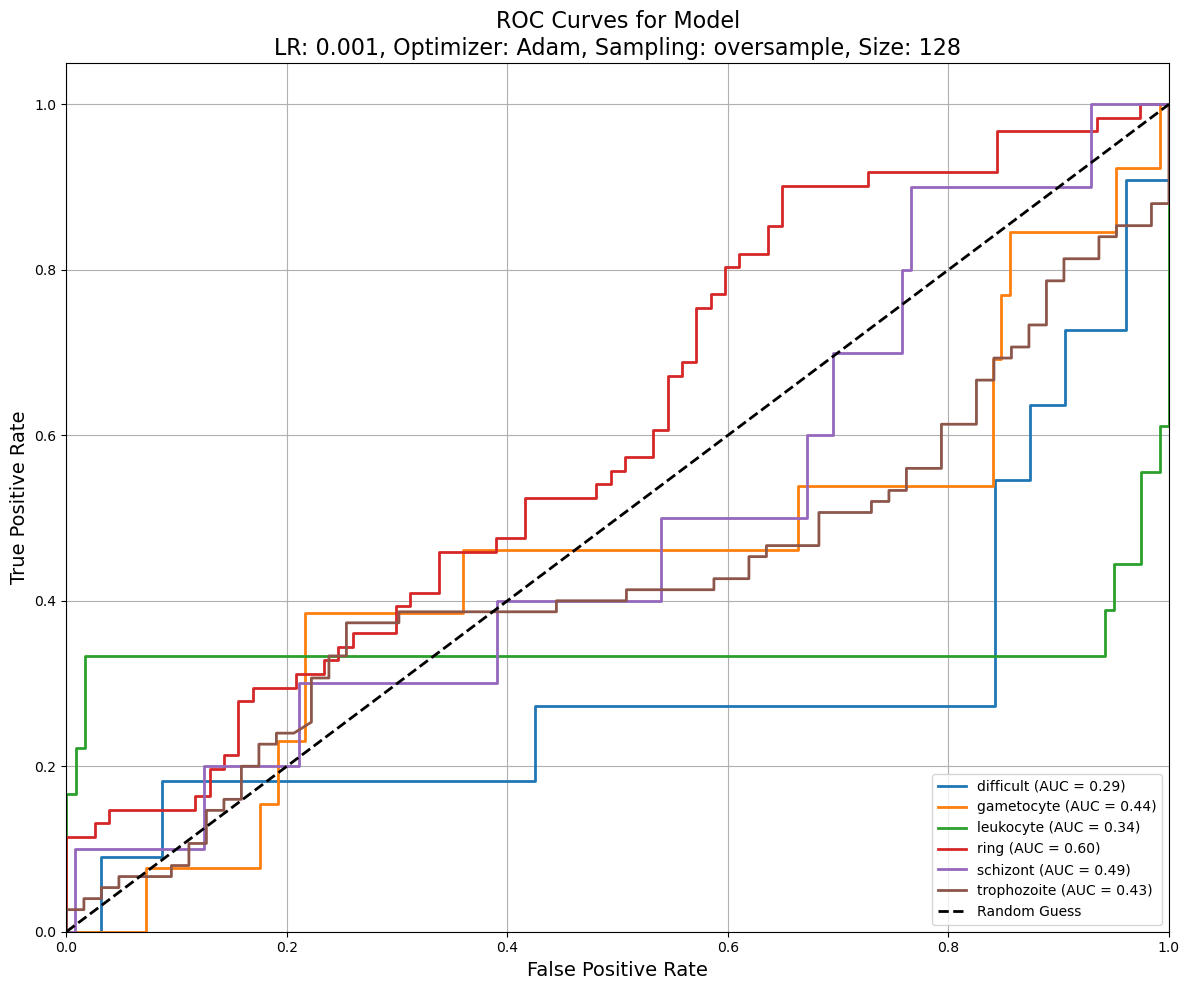

Generating ROC Curves:  19%|█▉        | 3/16 [00:53<03:46, 17.44s/it]C:\Users\shera\AppData\Local\Temp\ipykernel_21348\1472863007.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental f

Skipping ROC plot for red blood cell: only one class present.
Macro Average AUC: 0.6035


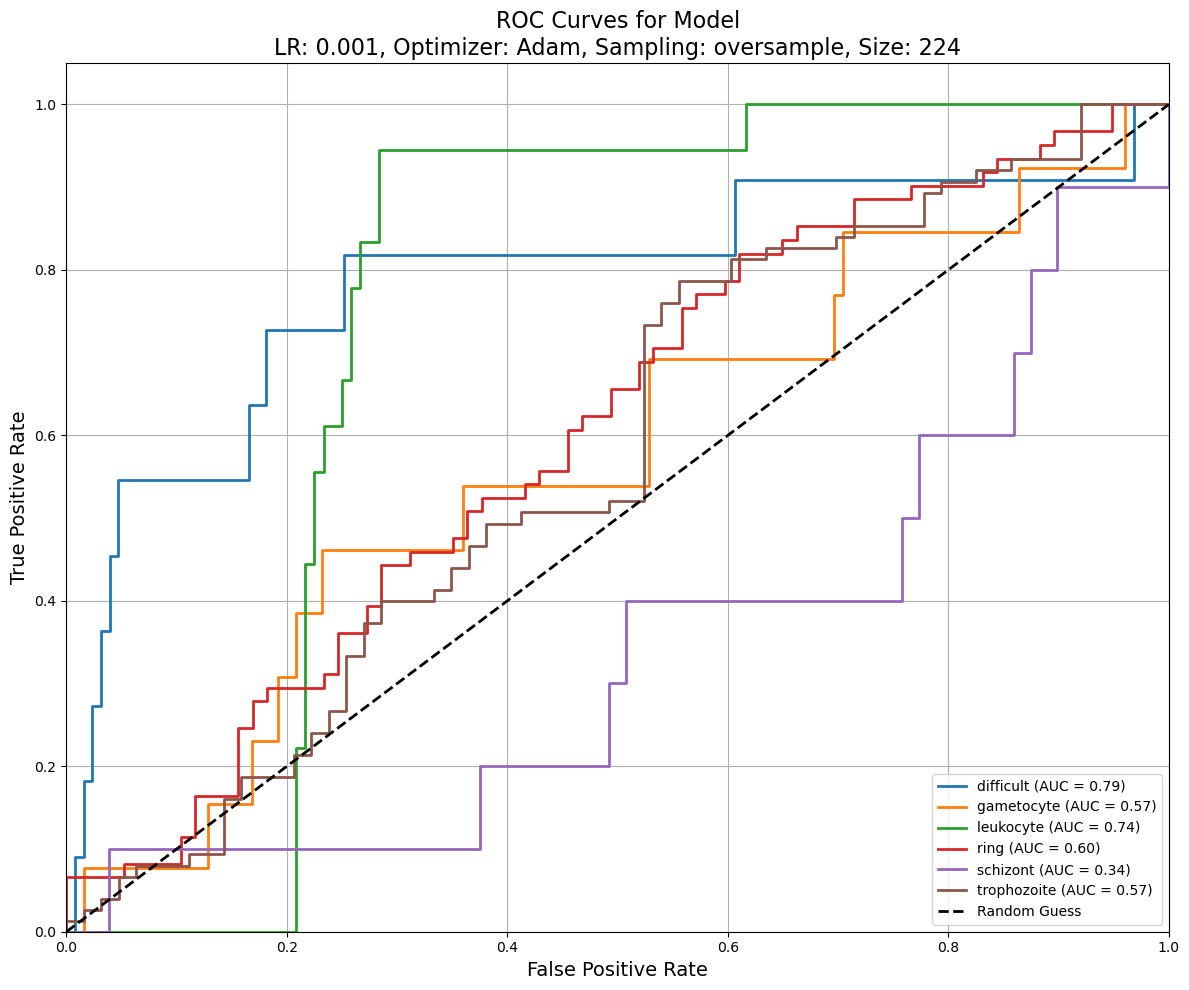

Skipping ROC plot for red blood cell: only one class present.
Macro Average AUC: 0.6035


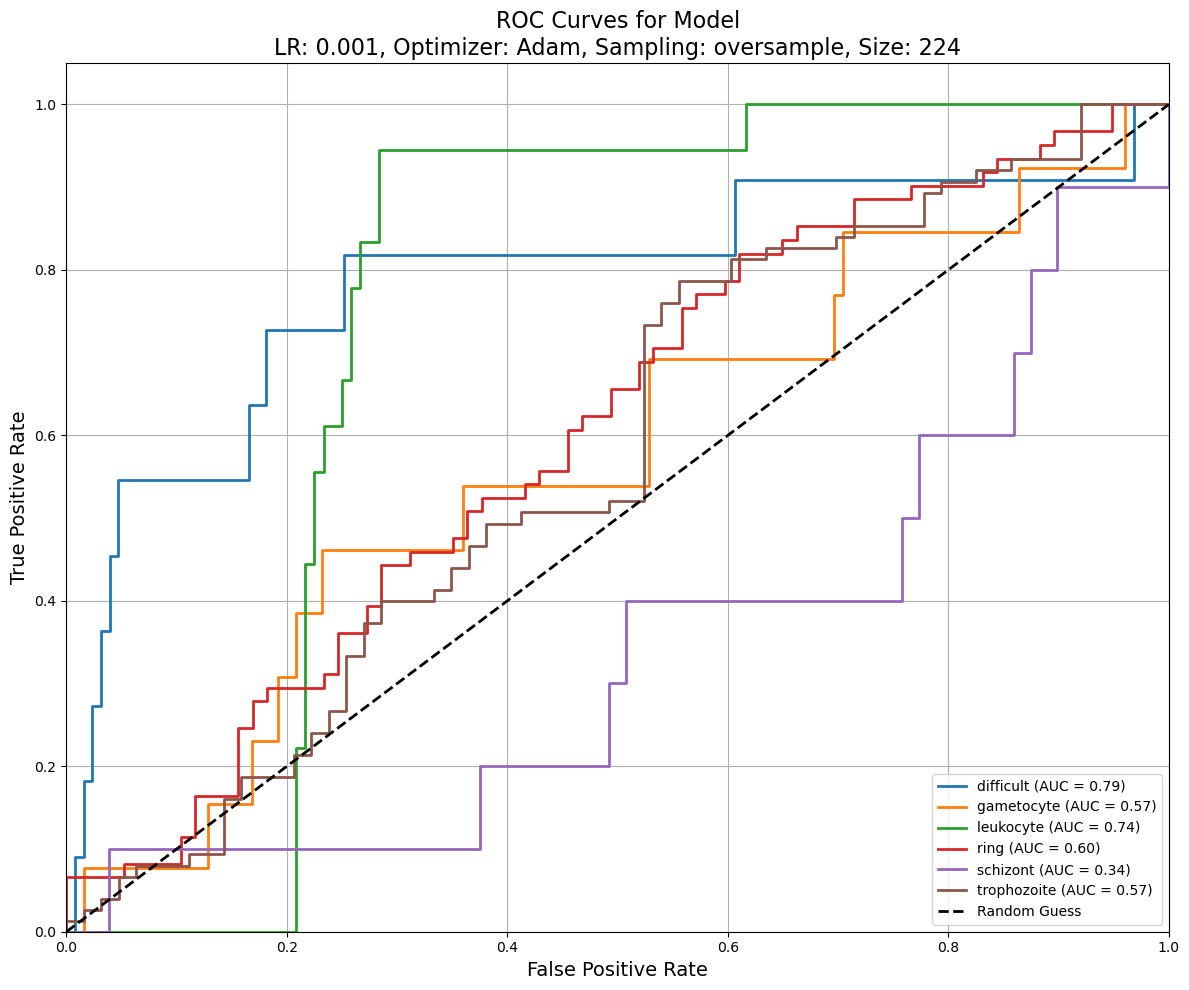

Generating ROC Curves:  25%|██▌       | 4/16 [01:08<03:20, 16.74s/it]C:\Users\shera\AppData\Local\Temp\ipykernel_21348\1472863007.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental f

Skipping ROC plot for red blood cell: only one class present.
Macro Average AUC: 0.5027


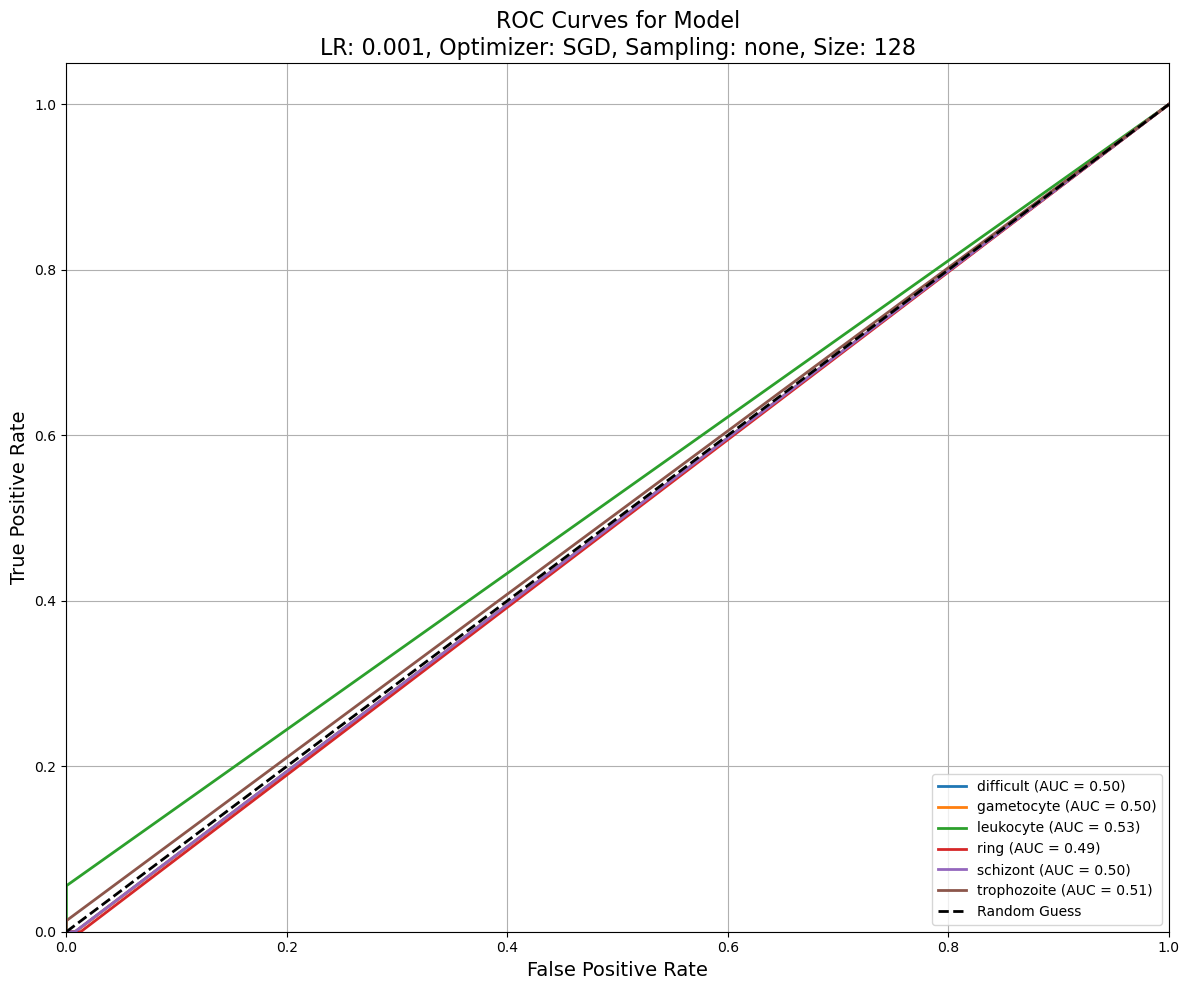

Skipping ROC plot for red blood cell: only one class present.
Macro Average AUC: 0.5027


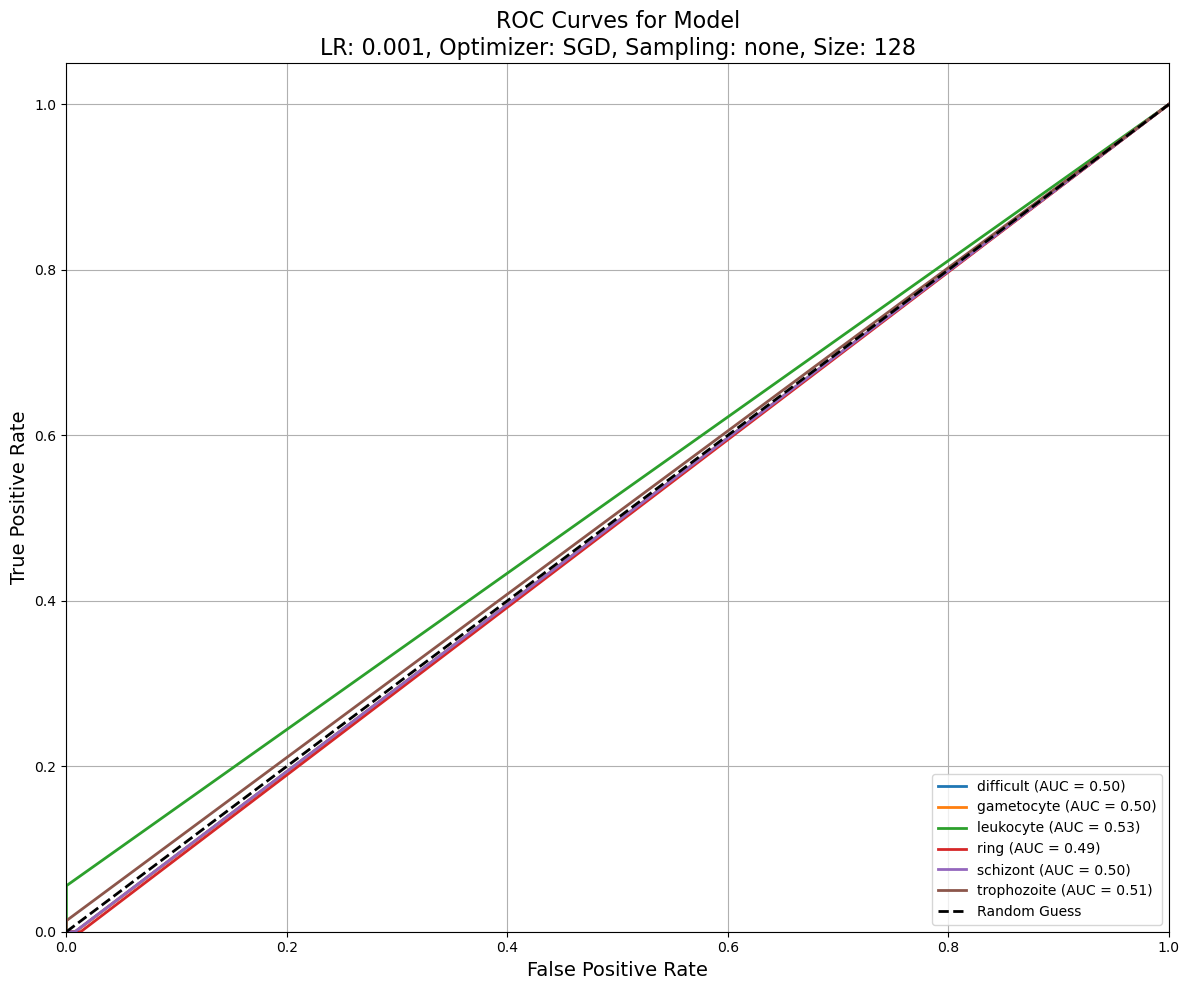

Generating ROC Curves:  31%|███▏      | 5/16 [01:25<03:05, 16.84s/it]C:\Users\shera\AppData\Local\Temp\ipykernel_21348\1472863007.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental f

Skipping ROC plot for red blood cell: only one class present.
Macro Average AUC: 0.4968


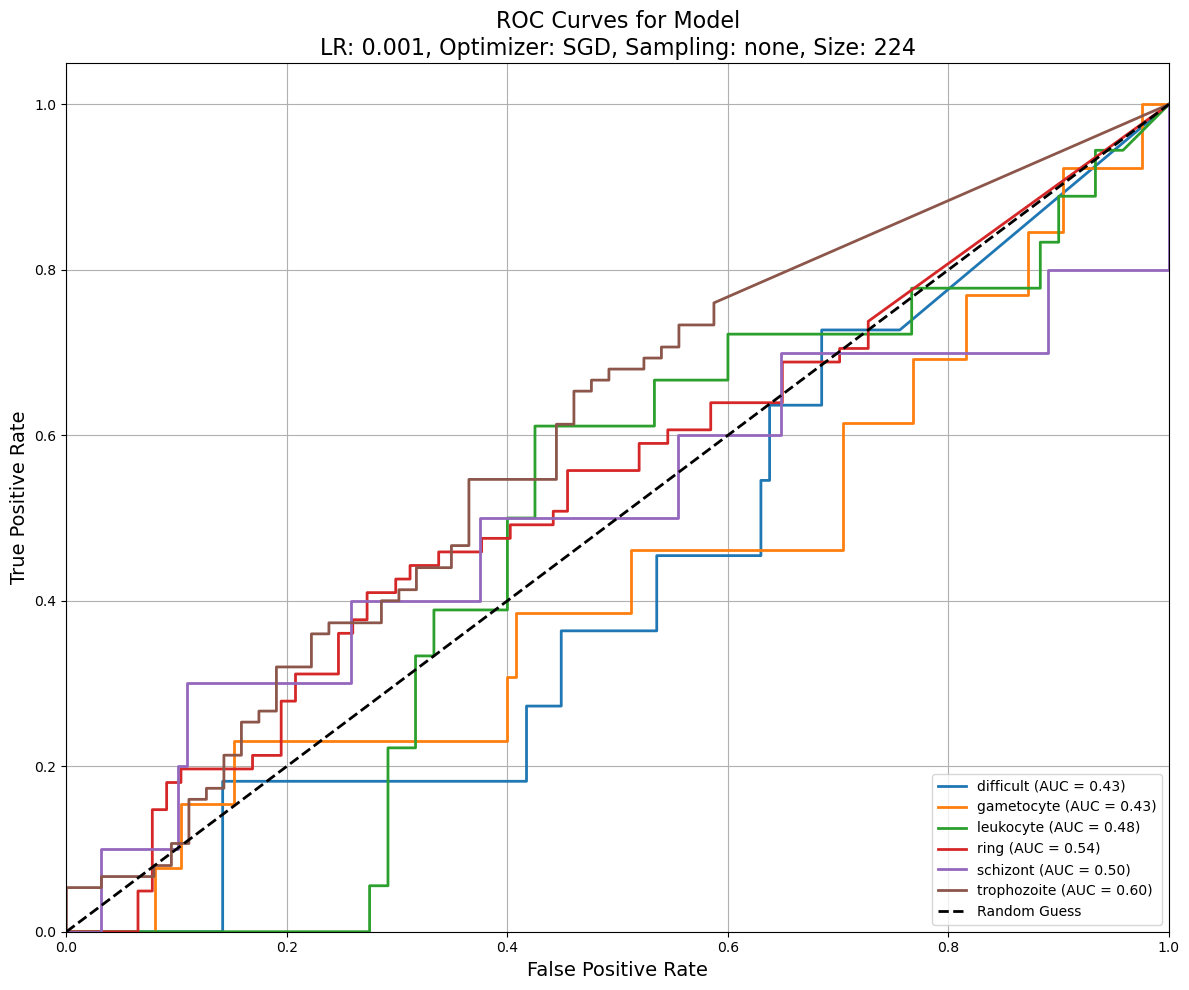

Skipping ROC plot for red blood cell: only one class present.
Macro Average AUC: 0.4968


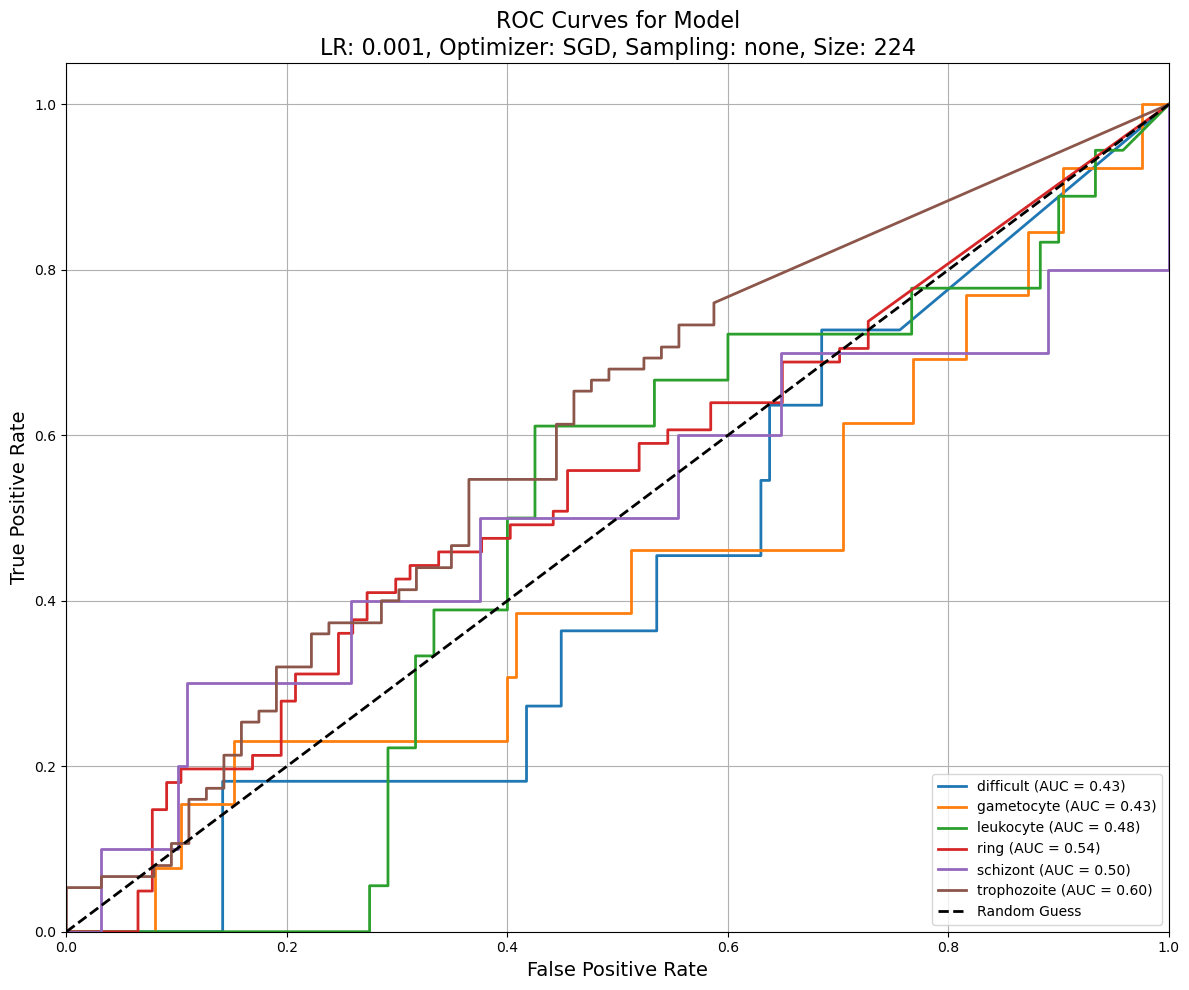

Generating ROC Curves:  38%|███▊      | 6/16 [01:43<02:52, 17.21s/it]C:\Users\shera\AppData\Local\Temp\ipykernel_21348\1472863007.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental f

Skipping ROC plot for red blood cell: only one class present.
Macro Average AUC: 0.5447


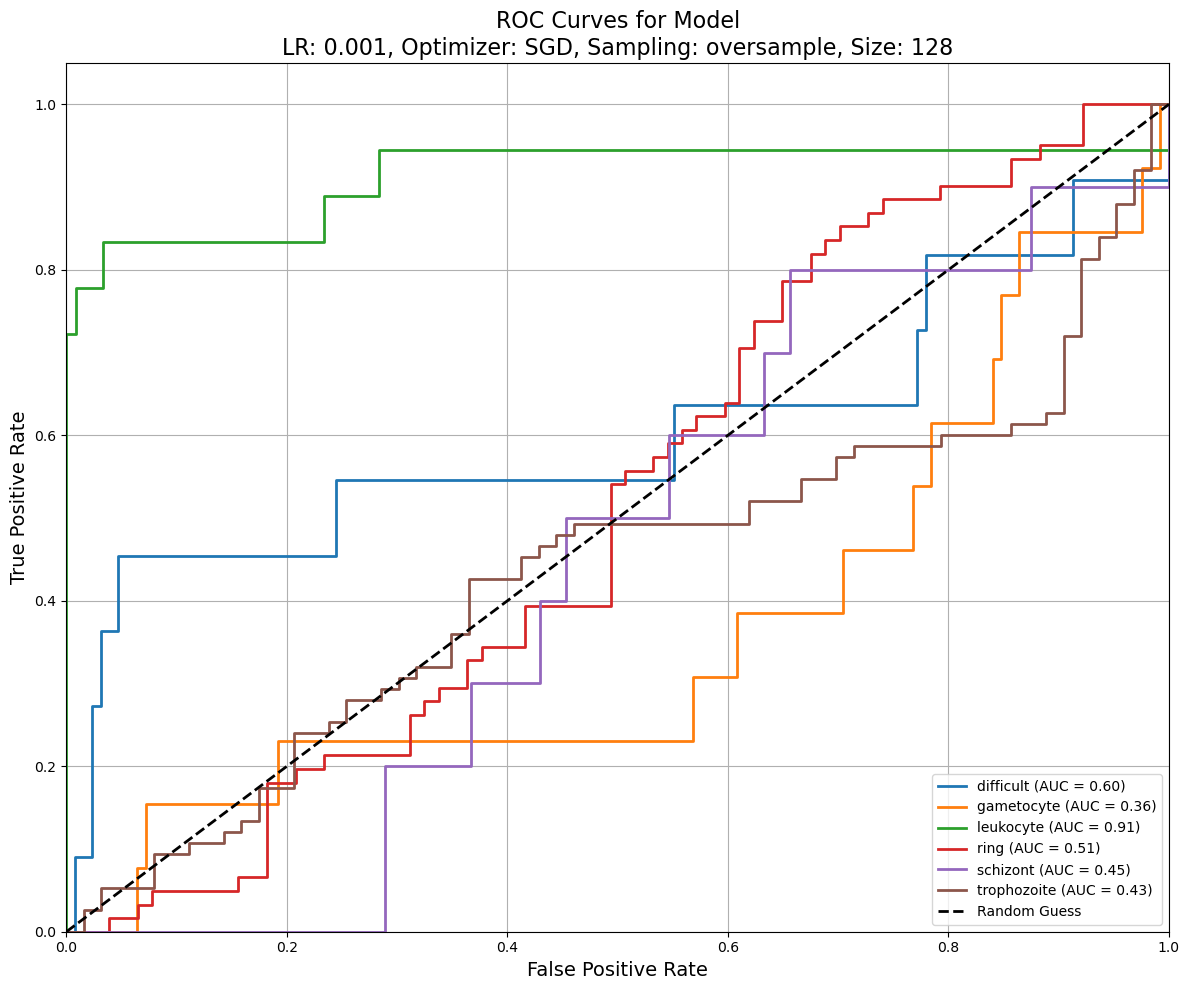

Skipping ROC plot for red blood cell: only one class present.
Macro Average AUC: 0.5447


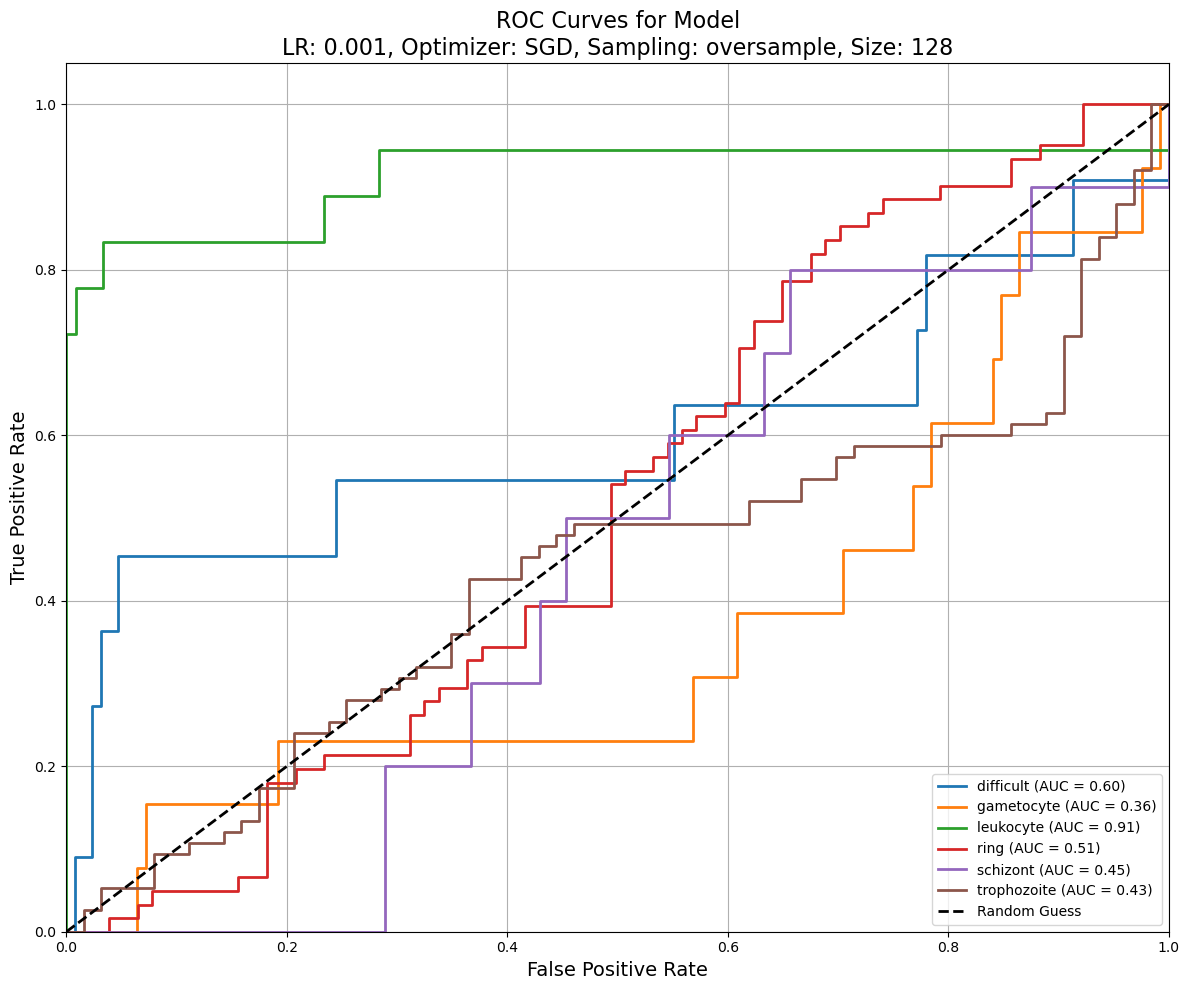

Generating ROC Curves:  44%|████▍     | 7/16 [02:00<02:33, 17.08s/it]C:\Users\shera\AppData\Local\Temp\ipykernel_21348\1472863007.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental f

Skipping ROC plot for red blood cell: only one class present.
Macro Average AUC: 0.5000


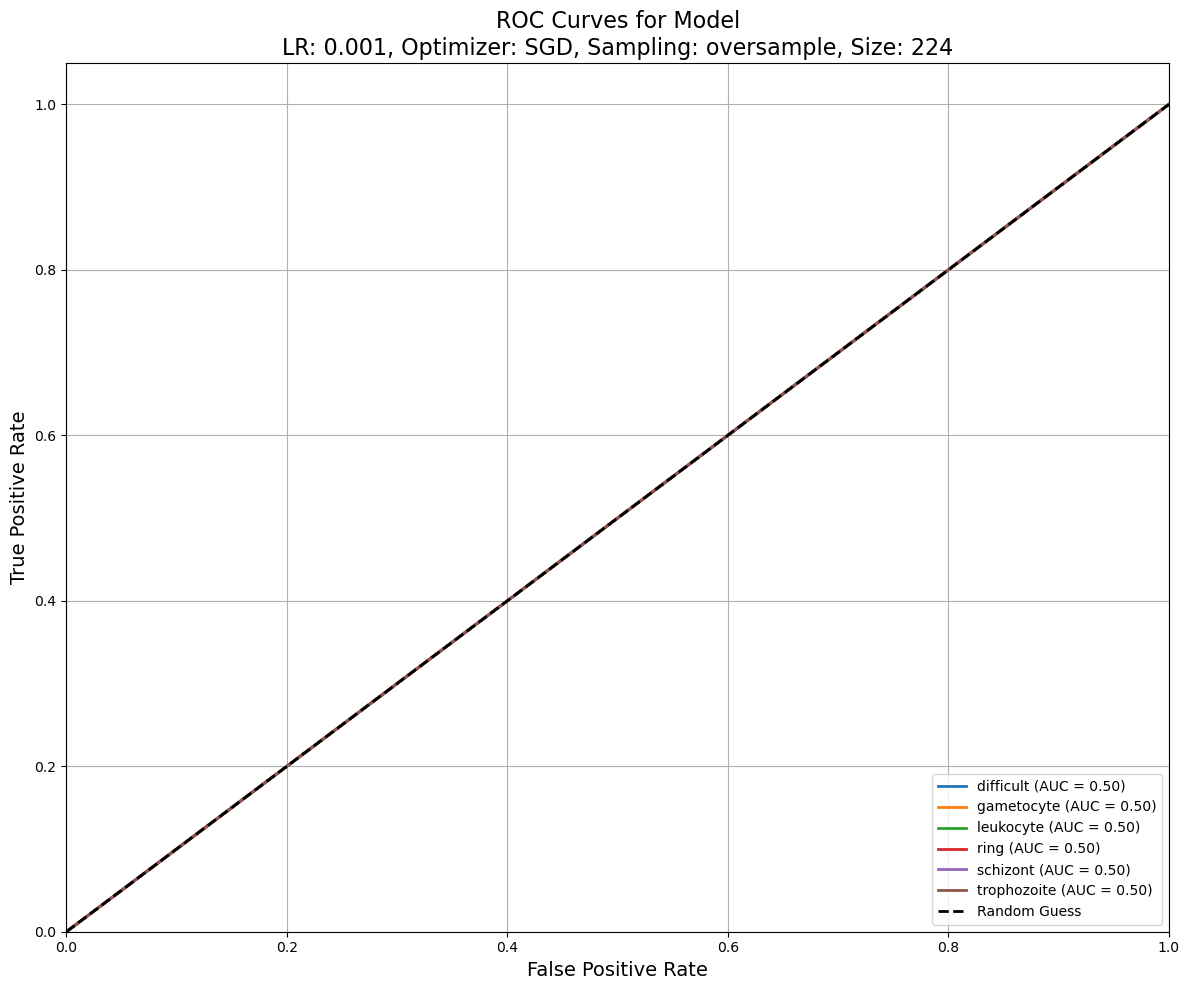

Skipping ROC plot for red blood cell: only one class present.
Macro Average AUC: 0.5000


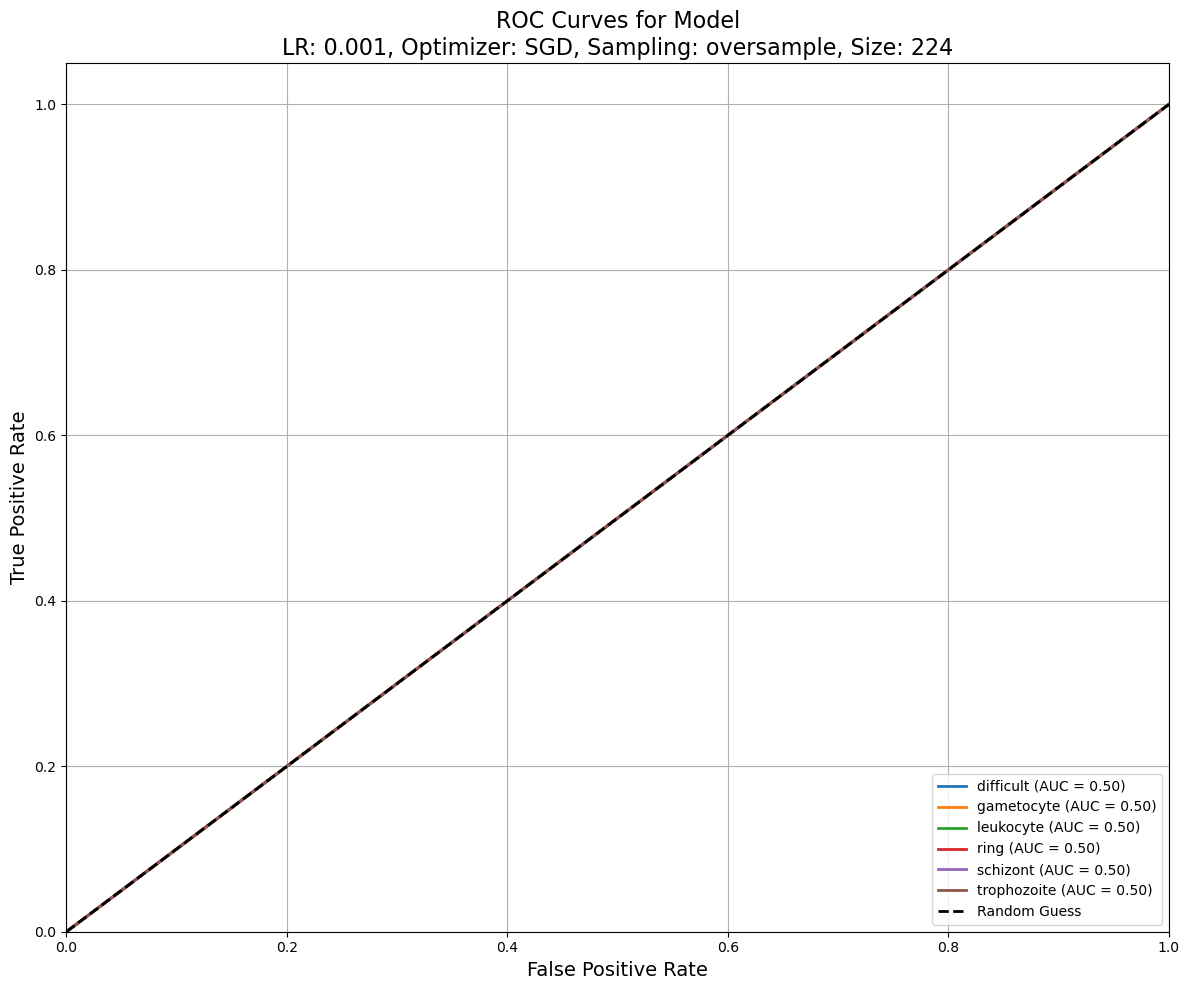

Generating ROC Curves:  50%|█████     | 8/16 [02:20<02:24, 18.06s/it]C:\Users\shera\AppData\Local\Temp\ipykernel_21348\1472863007.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental f

Skipping ROC plot for red blood cell: only one class present.
Macro Average AUC: 0.5446


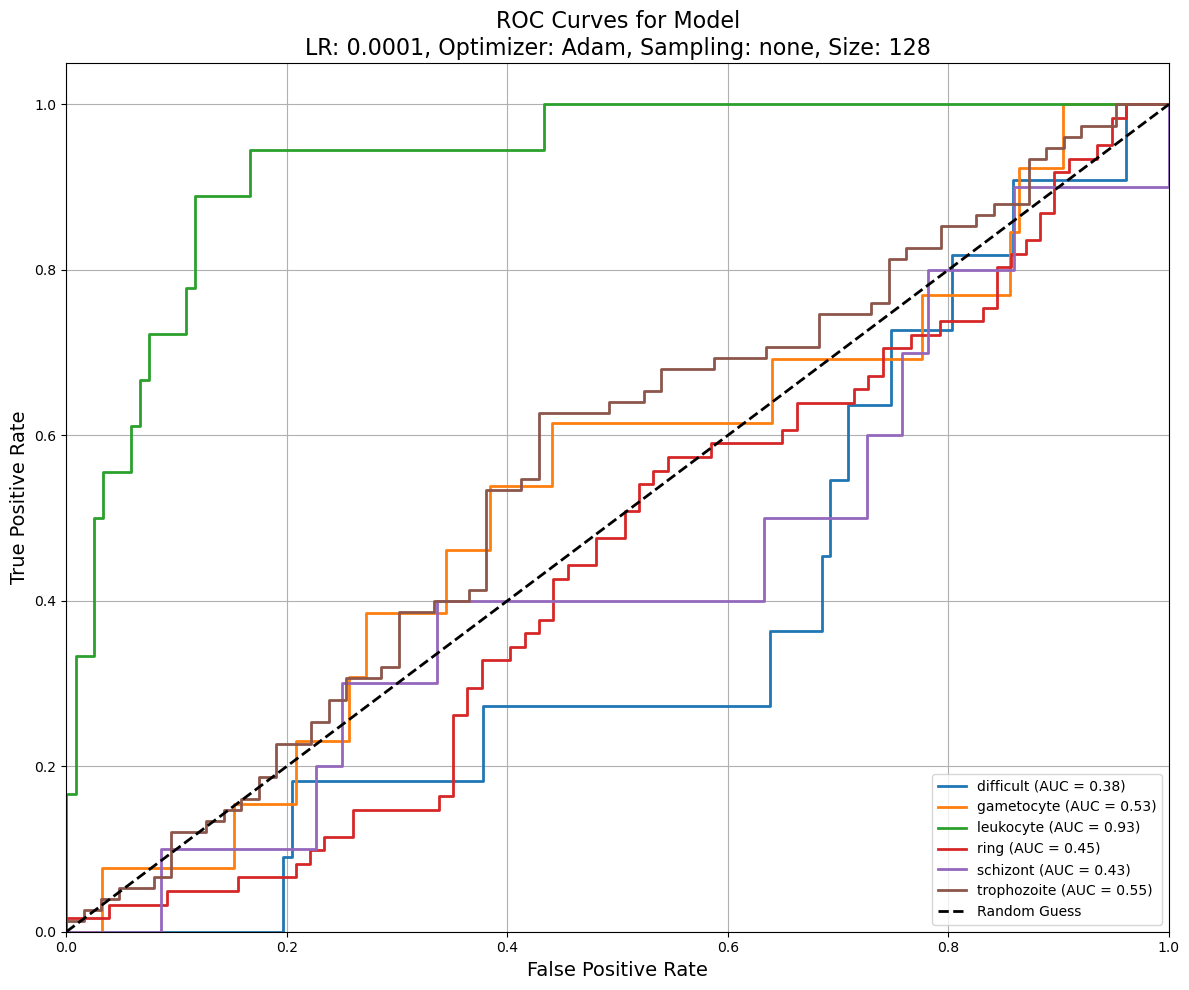

Skipping ROC plot for red blood cell: only one class present.
Macro Average AUC: 0.5446


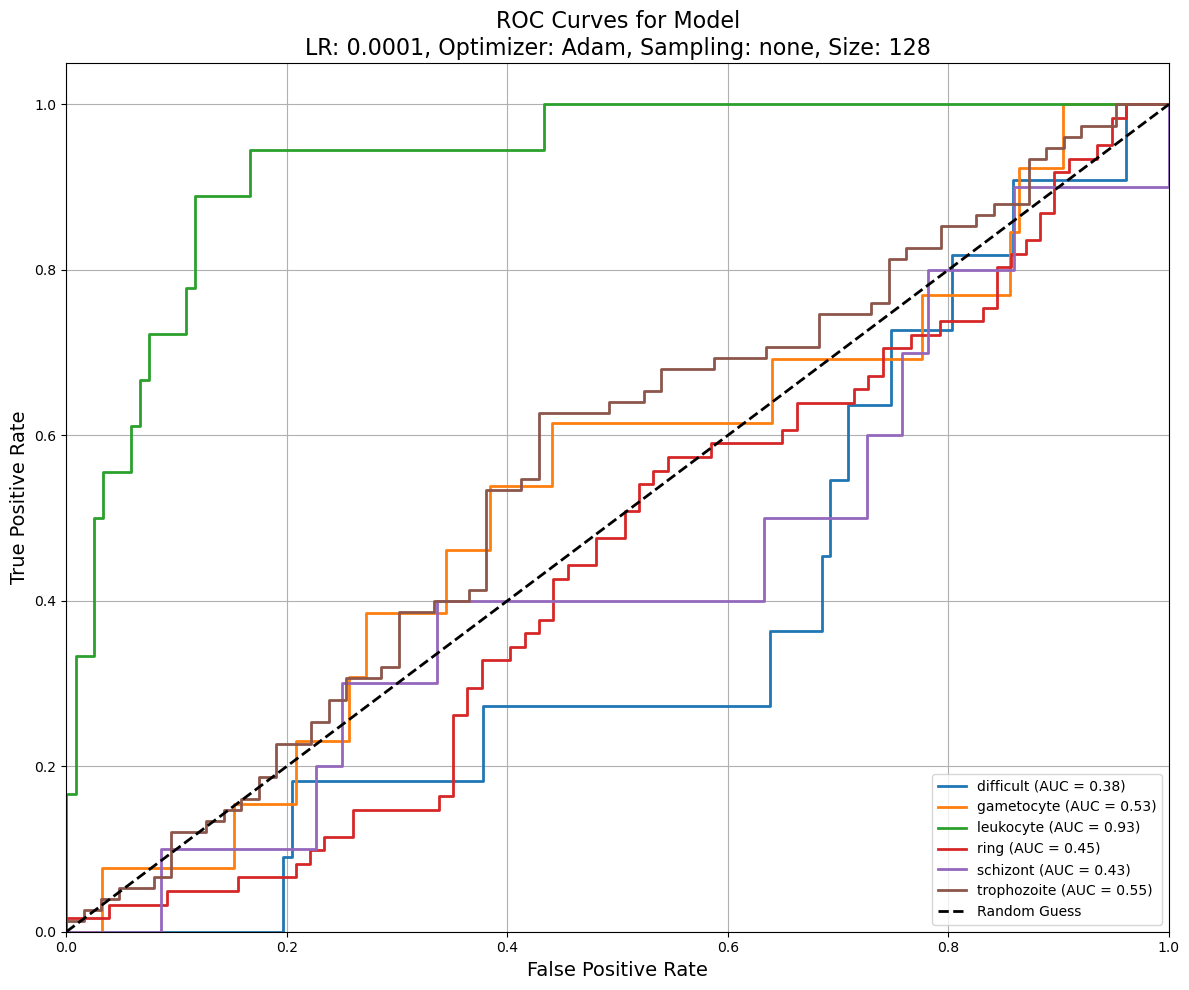

Generating ROC Curves:  56%|█████▋    | 9/16 [02:38<02:06, 18.14s/it]C:\Users\shera\AppData\Local\Temp\ipykernel_21348\1472863007.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental f

Skipping ROC plot for red blood cell: only one class present.
Macro Average AUC: 0.6488


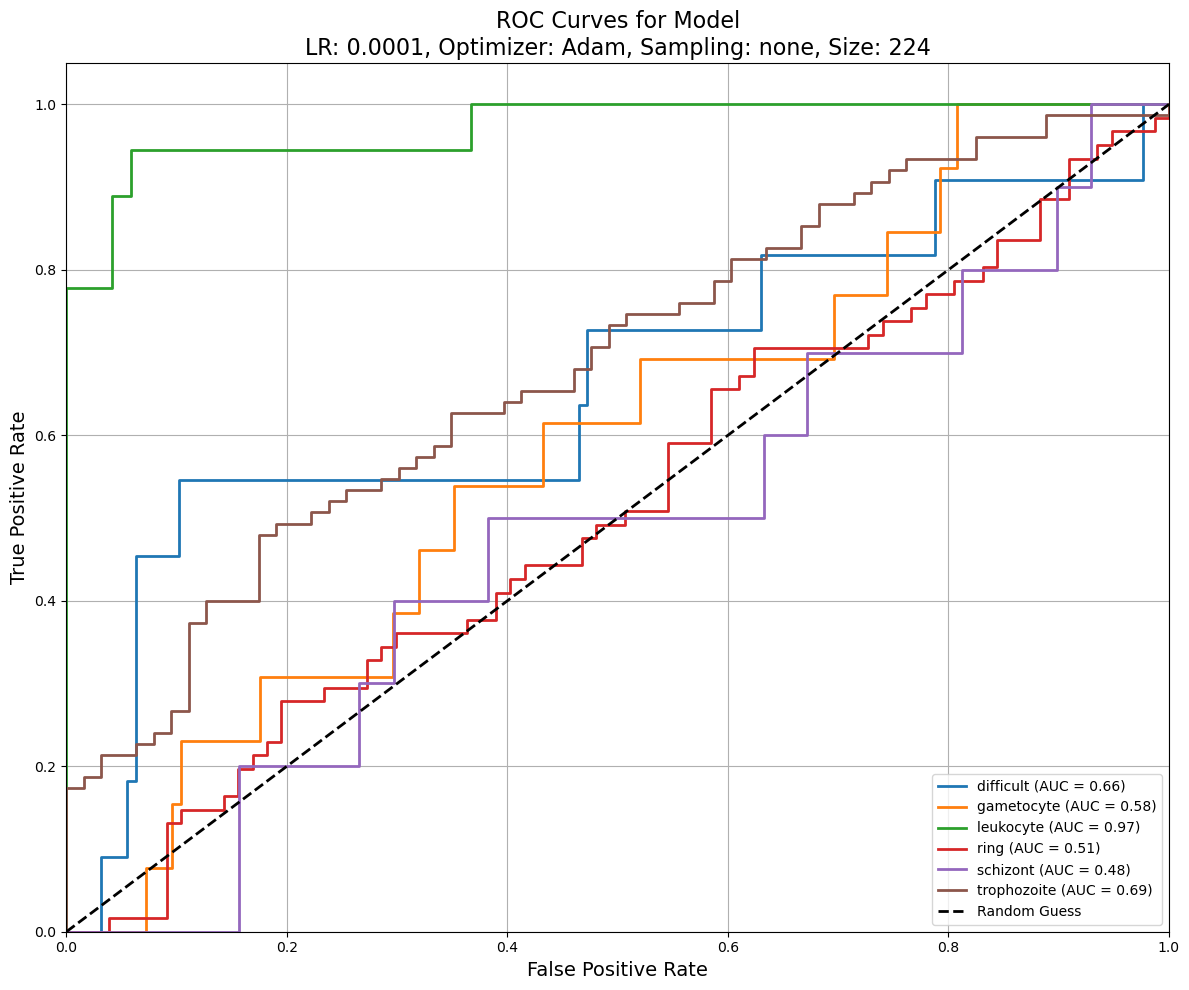

Skipping ROC plot for red blood cell: only one class present.
Macro Average AUC: 0.6488


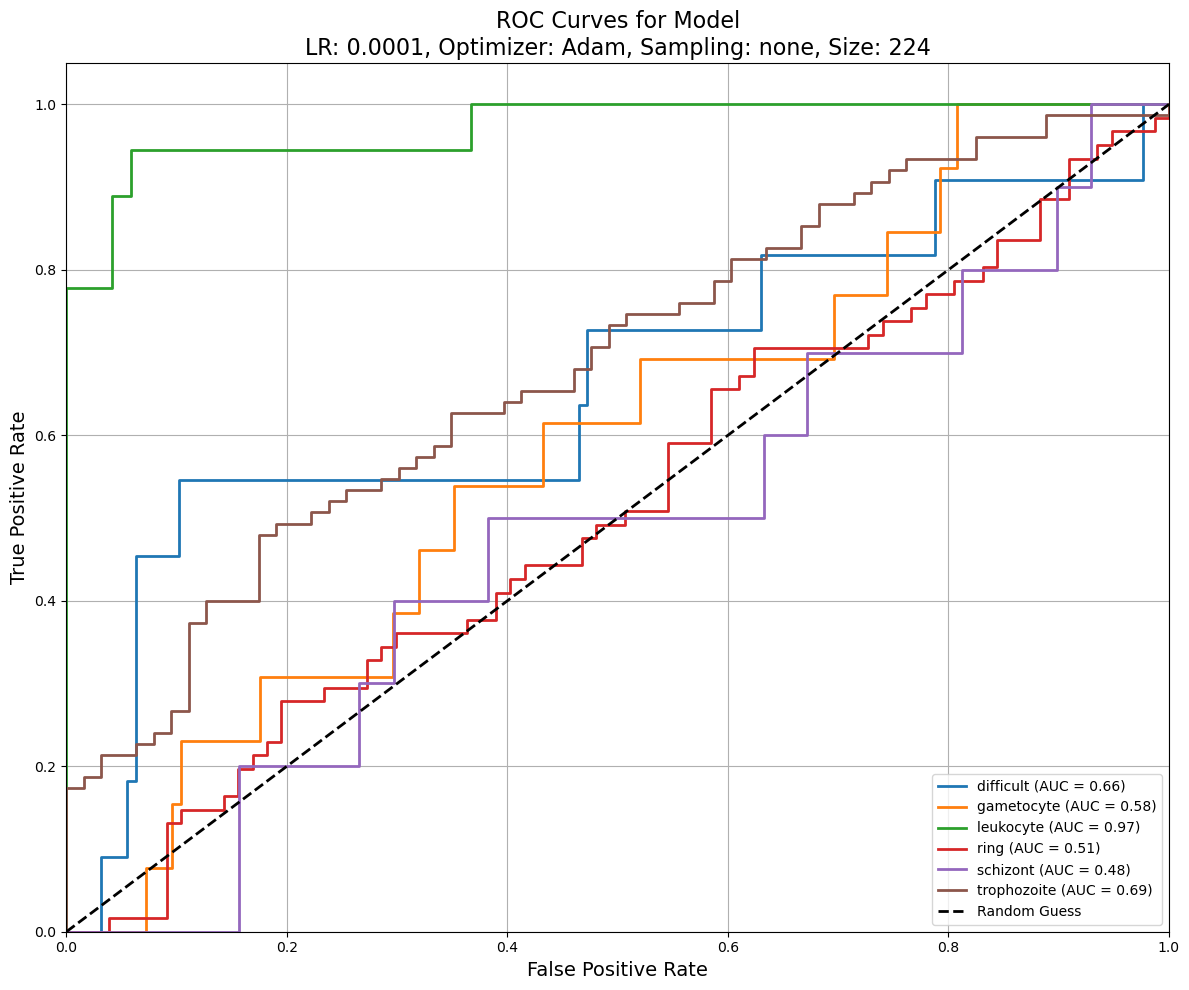

Generating ROC Curves:  62%|██████▎   | 10/16 [02:56<01:48, 18.05s/it]C:\Users\shera\AppData\Local\Temp\ipykernel_21348\1472863007.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental 

Skipping ROC plot for red blood cell: only one class present.
Macro Average AUC: 0.5704


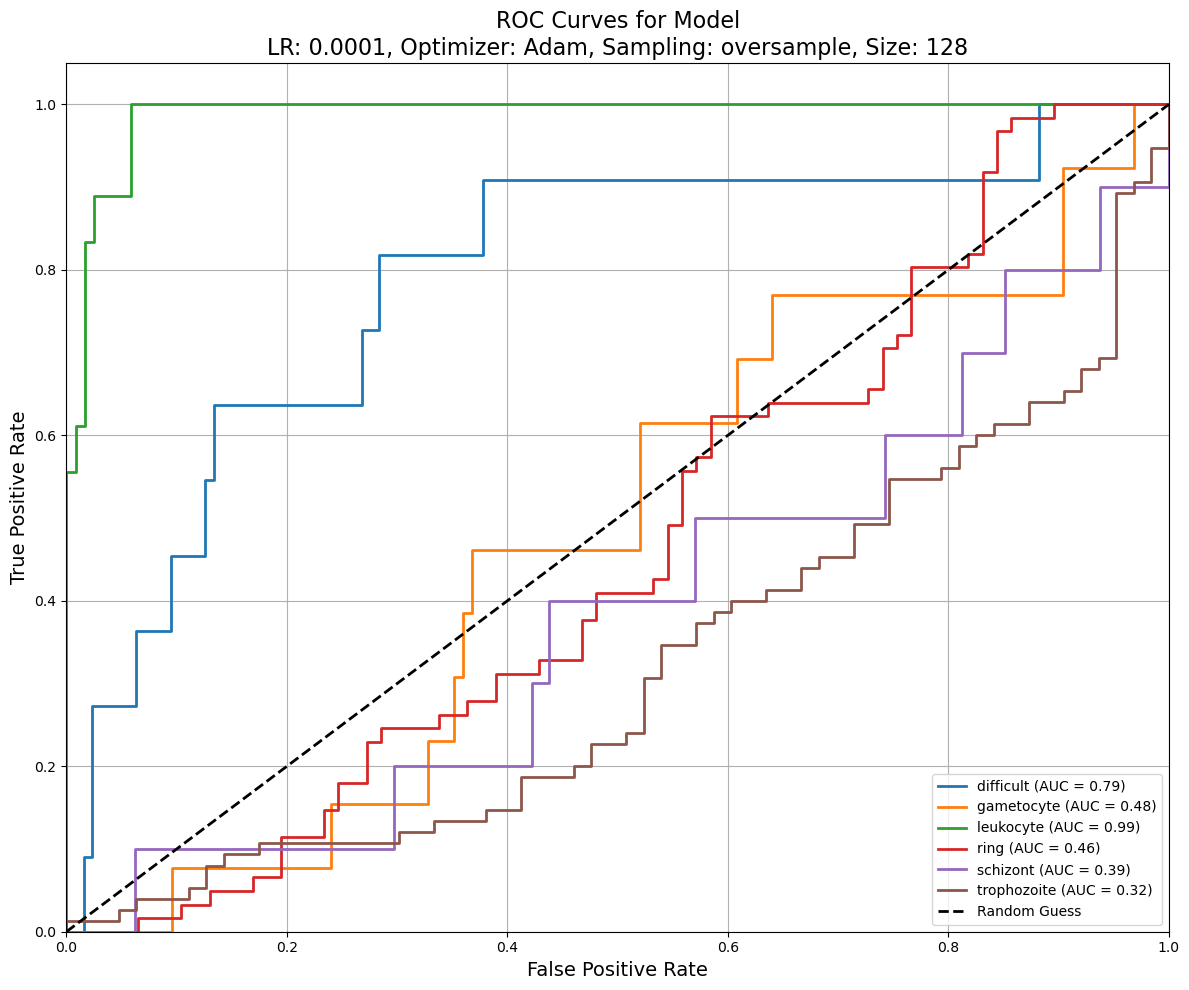

Skipping ROC plot for red blood cell: only one class present.
Macro Average AUC: 0.5704


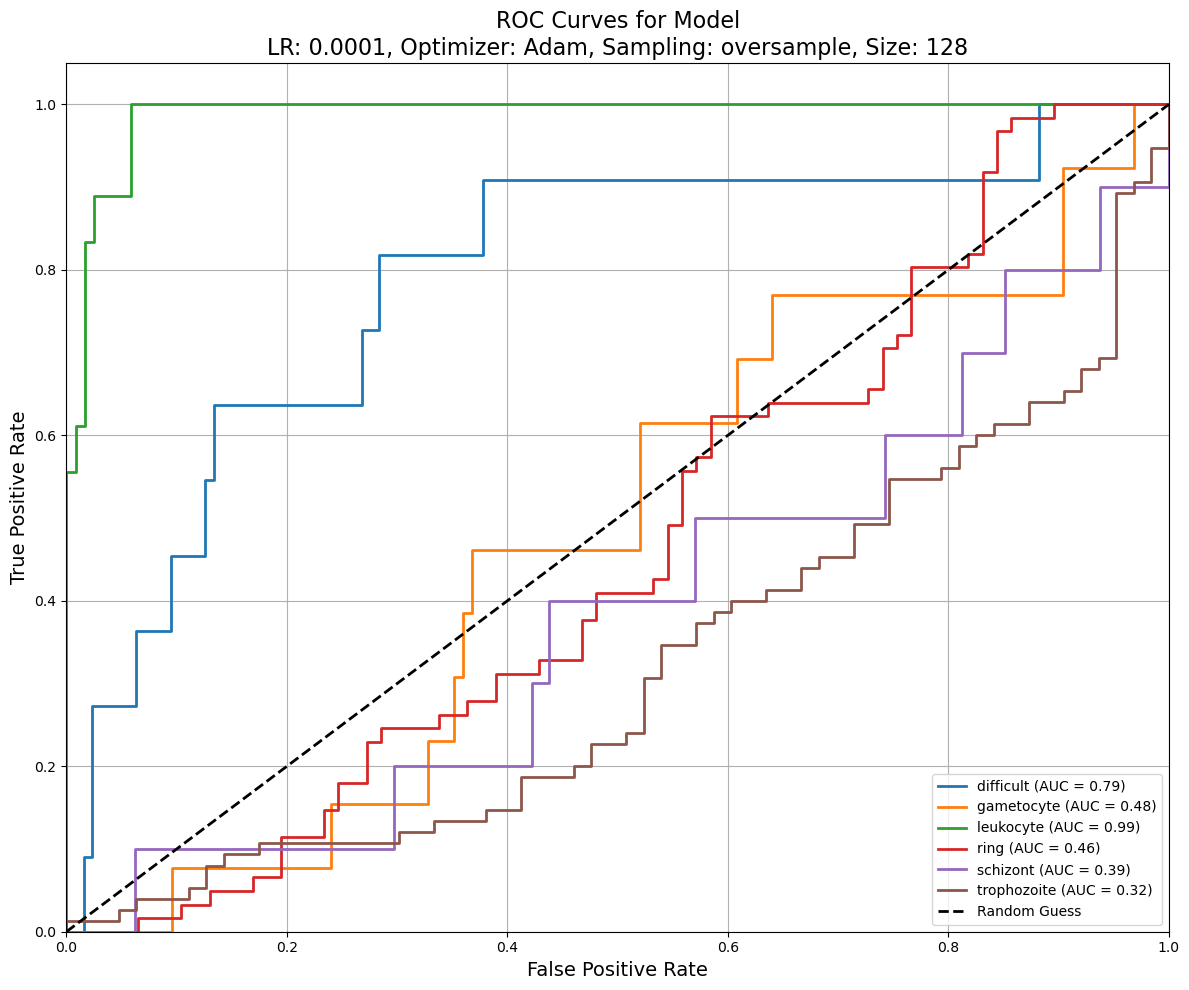

Generating ROC Curves:  69%|██████▉   | 11/16 [03:14<01:29, 17.88s/it]C:\Users\shera\AppData\Local\Temp\ipykernel_21348\1472863007.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental 

Skipping ROC plot for red blood cell: only one class present.
Macro Average AUC: 0.5630


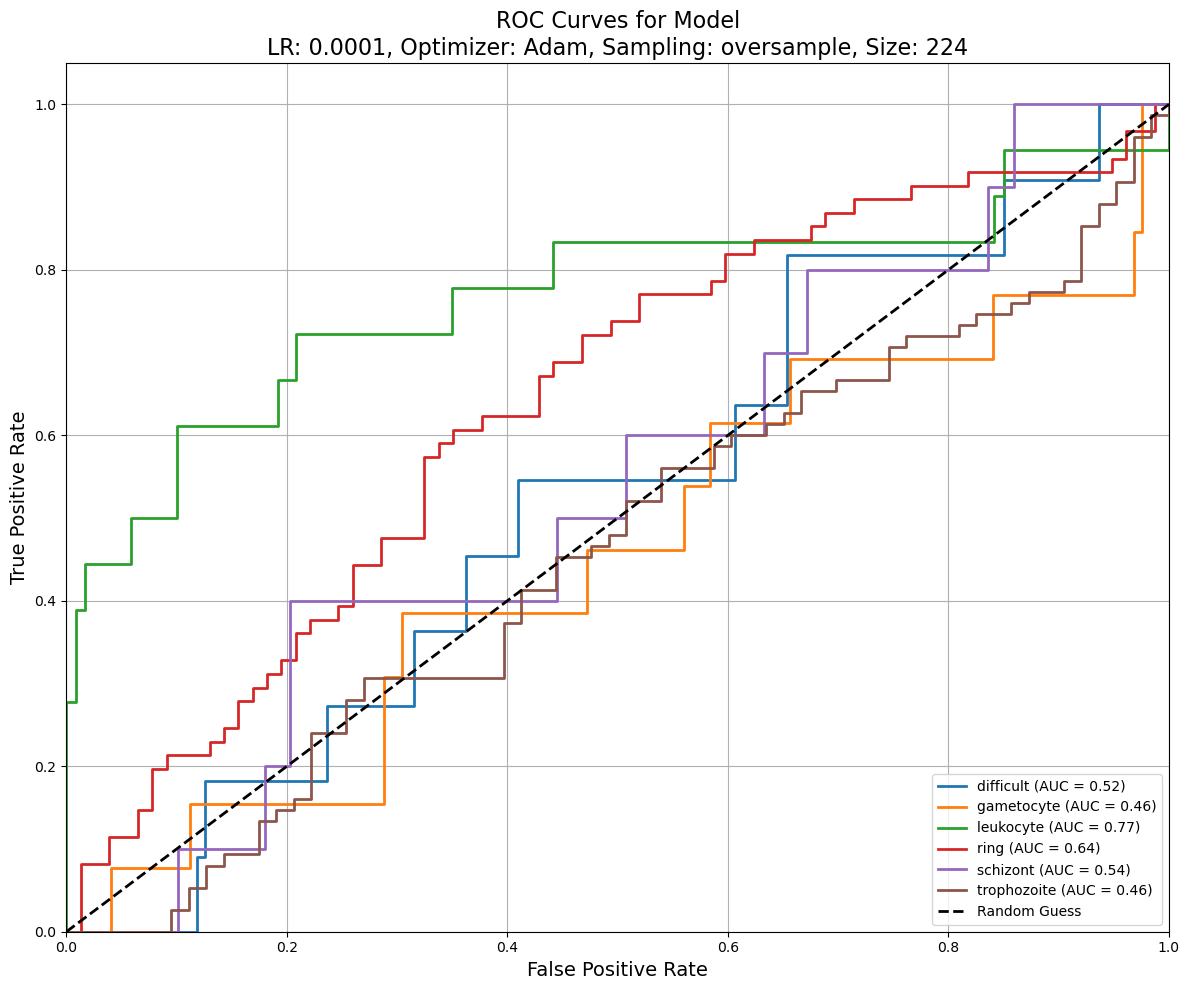

Skipping ROC plot for red blood cell: only one class present.
Macro Average AUC: 0.5630


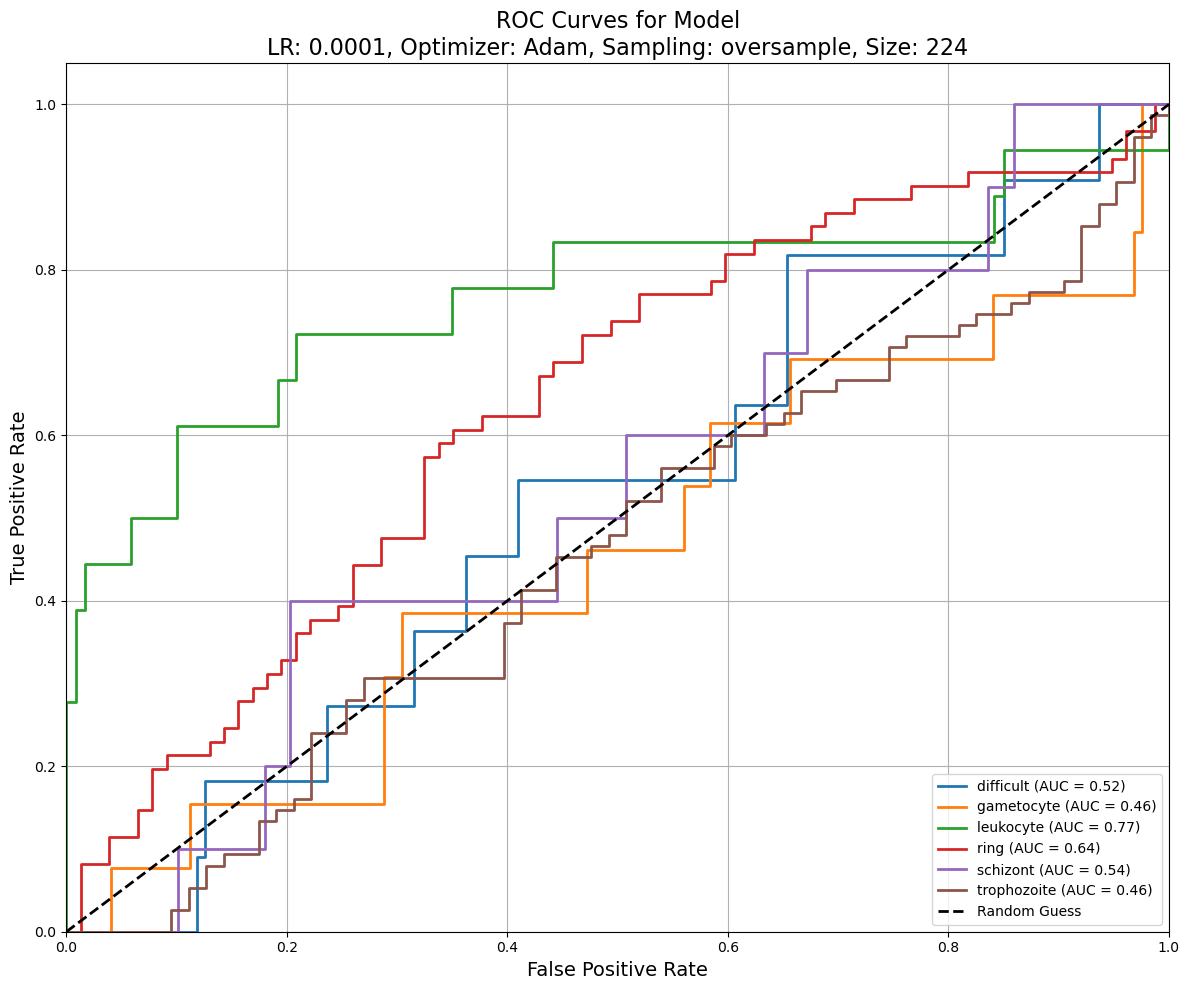

Generating ROC Curves:  75%|███████▌  | 12/16 [03:31<01:10, 17.56s/it]C:\Users\shera\AppData\Local\Temp\ipykernel_21348\1472863007.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental 

Skipping ROC plot for red blood cell: only one class present.
Macro Average AUC: 0.5883


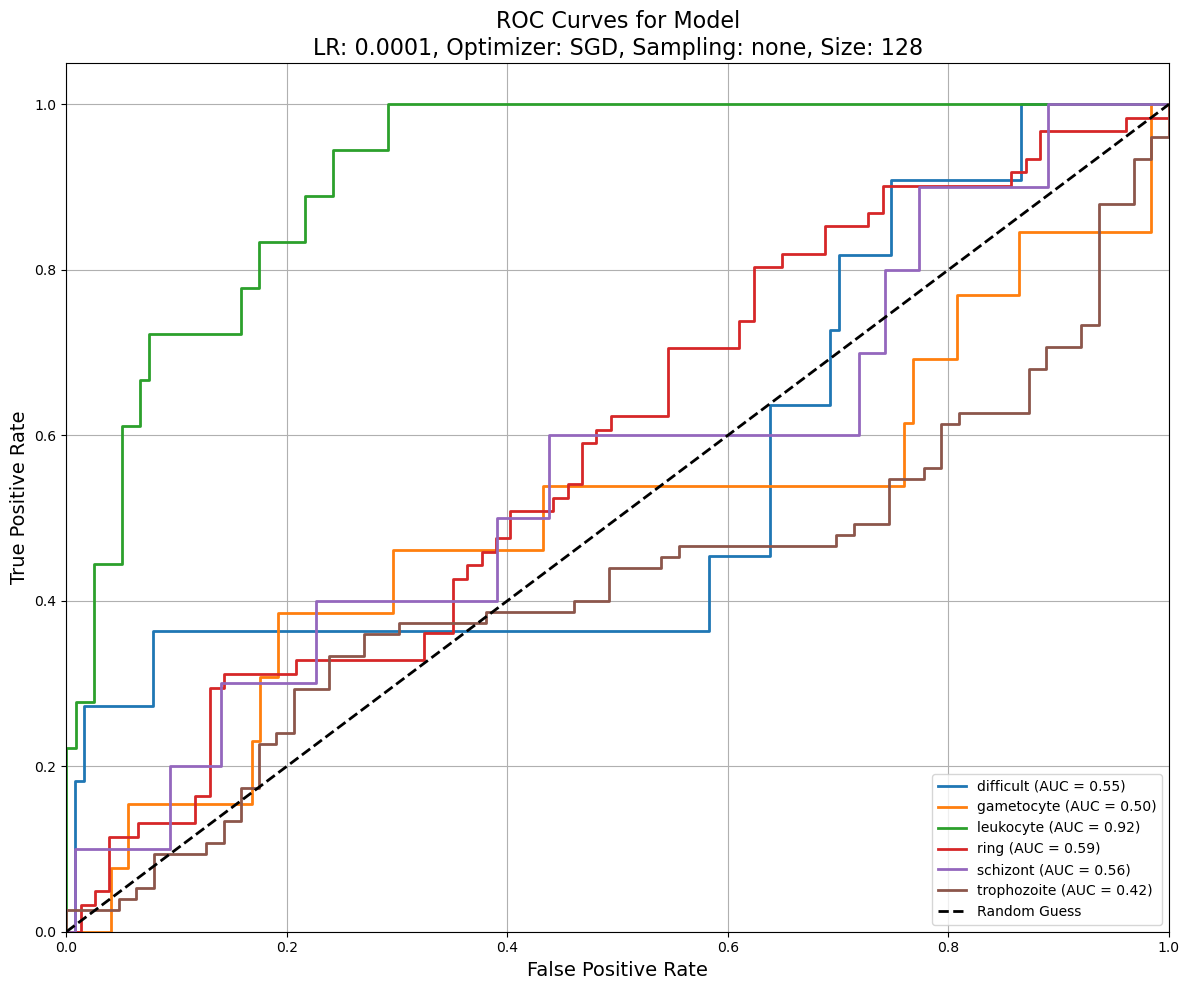

Skipping ROC plot for red blood cell: only one class present.
Macro Average AUC: 0.5883


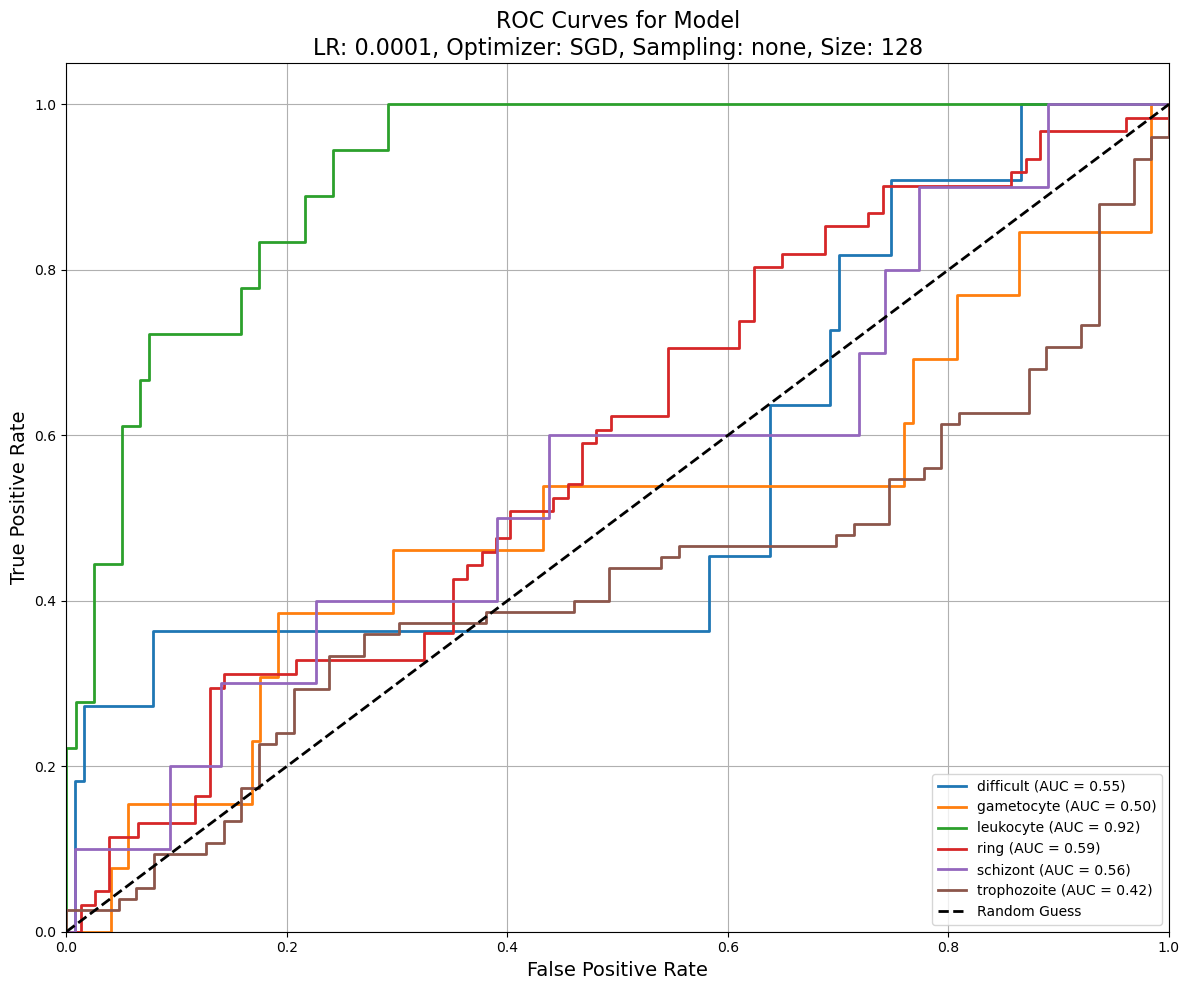

Generating ROC Curves:  81%|████████▏ | 13/16 [03:47<00:51, 17.20s/it]C:\Users\shera\AppData\Local\Temp\ipykernel_21348\1472863007.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental 

Skipping ROC plot for red blood cell: only one class present.
Macro Average AUC: 0.4335


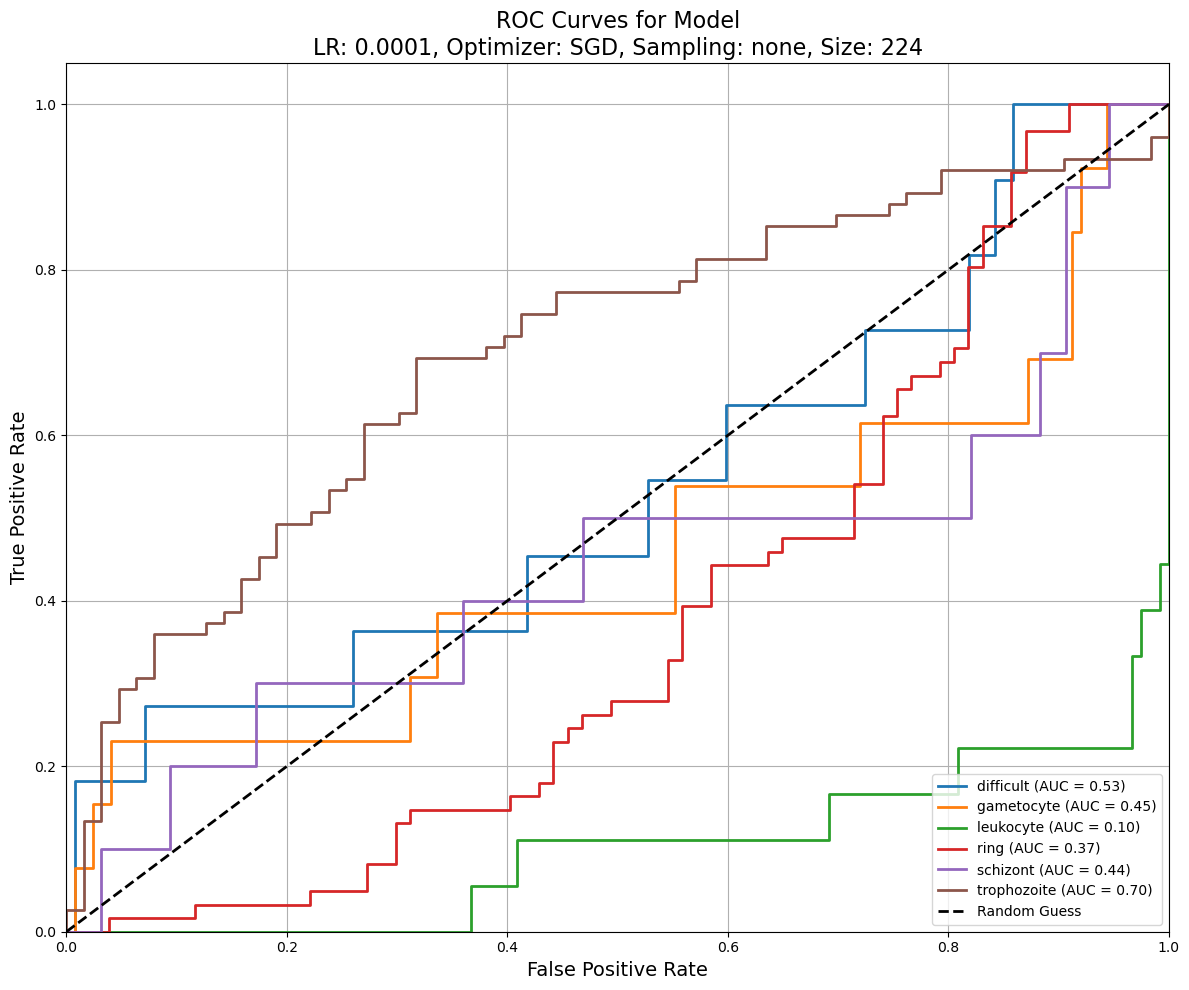

Skipping ROC plot for red blood cell: only one class present.
Macro Average AUC: 0.4335


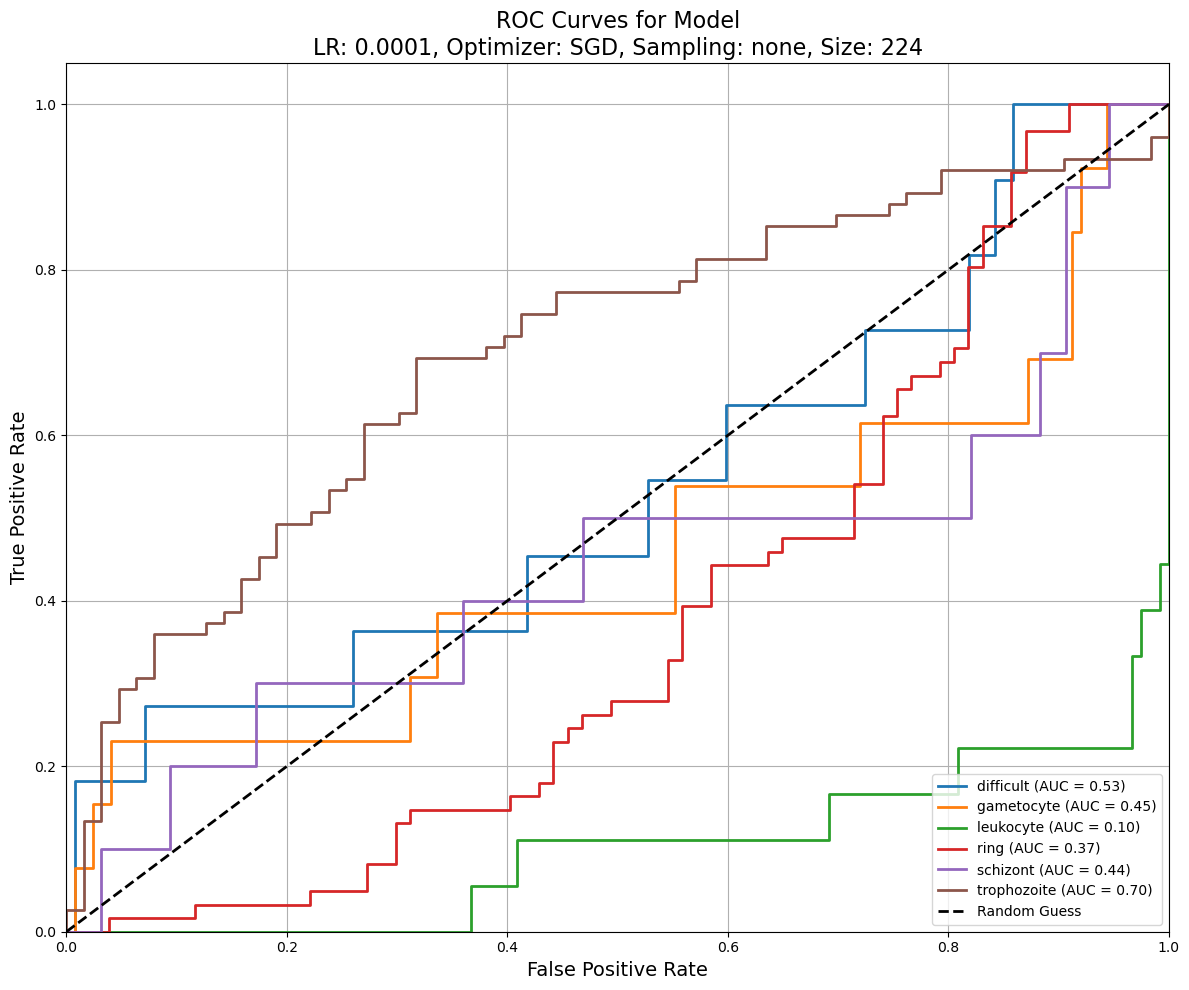

Generating ROC Curves:  88%|████████▊ | 14/16 [04:04<00:34, 17.17s/it]C:\Users\shera\AppData\Local\Temp\ipykernel_21348\1472863007.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental 

Skipping ROC plot for red blood cell: only one class present.
Macro Average AUC: 0.4869


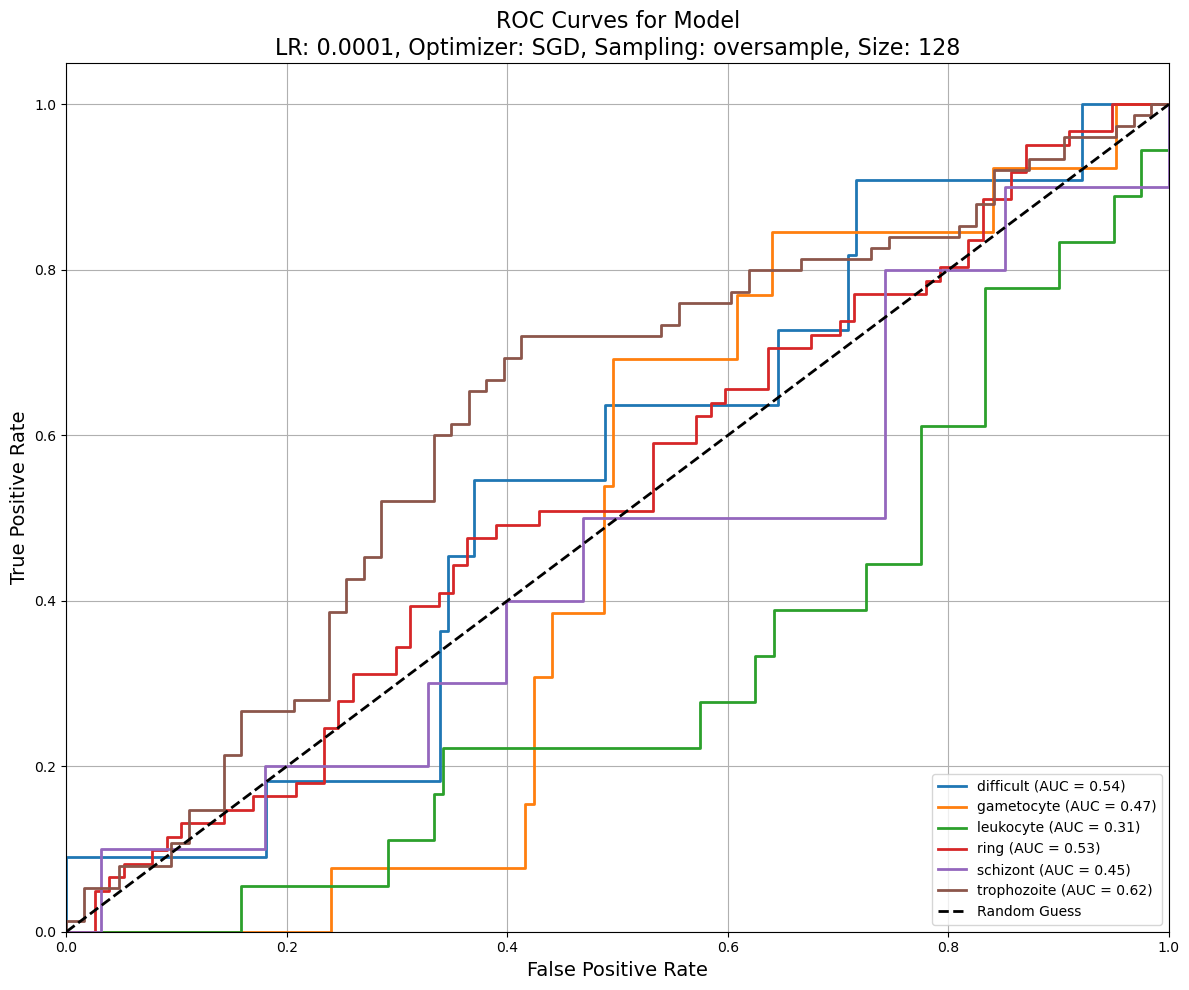

Skipping ROC plot for red blood cell: only one class present.
Macro Average AUC: 0.4869


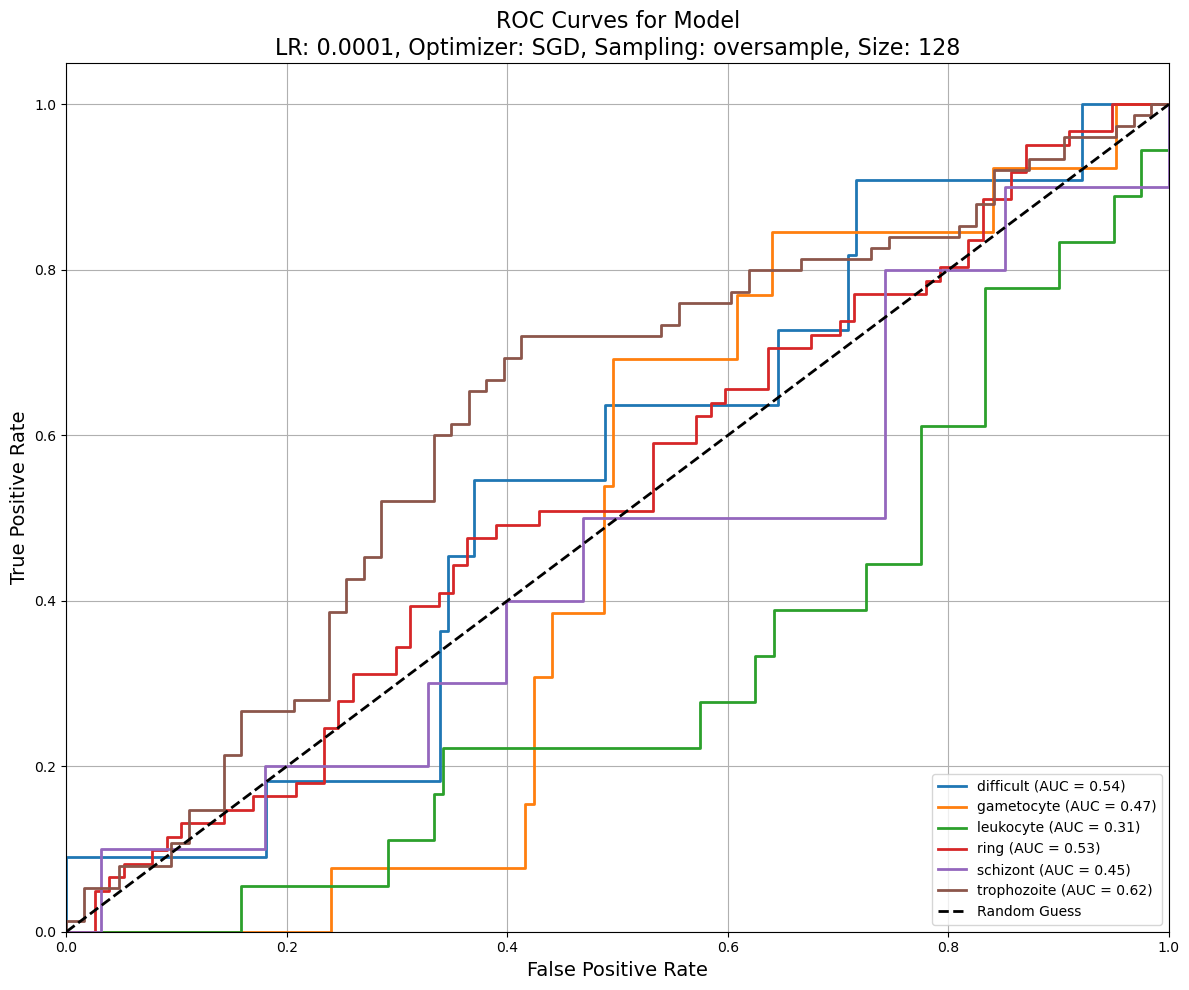

Generating ROC Curves:  94%|█████████▍| 15/16 [04:20<00:16, 16.90s/it]C:\Users\shera\AppData\Local\Temp\ipykernel_21348\1472863007.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental 

Skipping ROC plot for red blood cell: only one class present.
Macro Average AUC: 0.4549


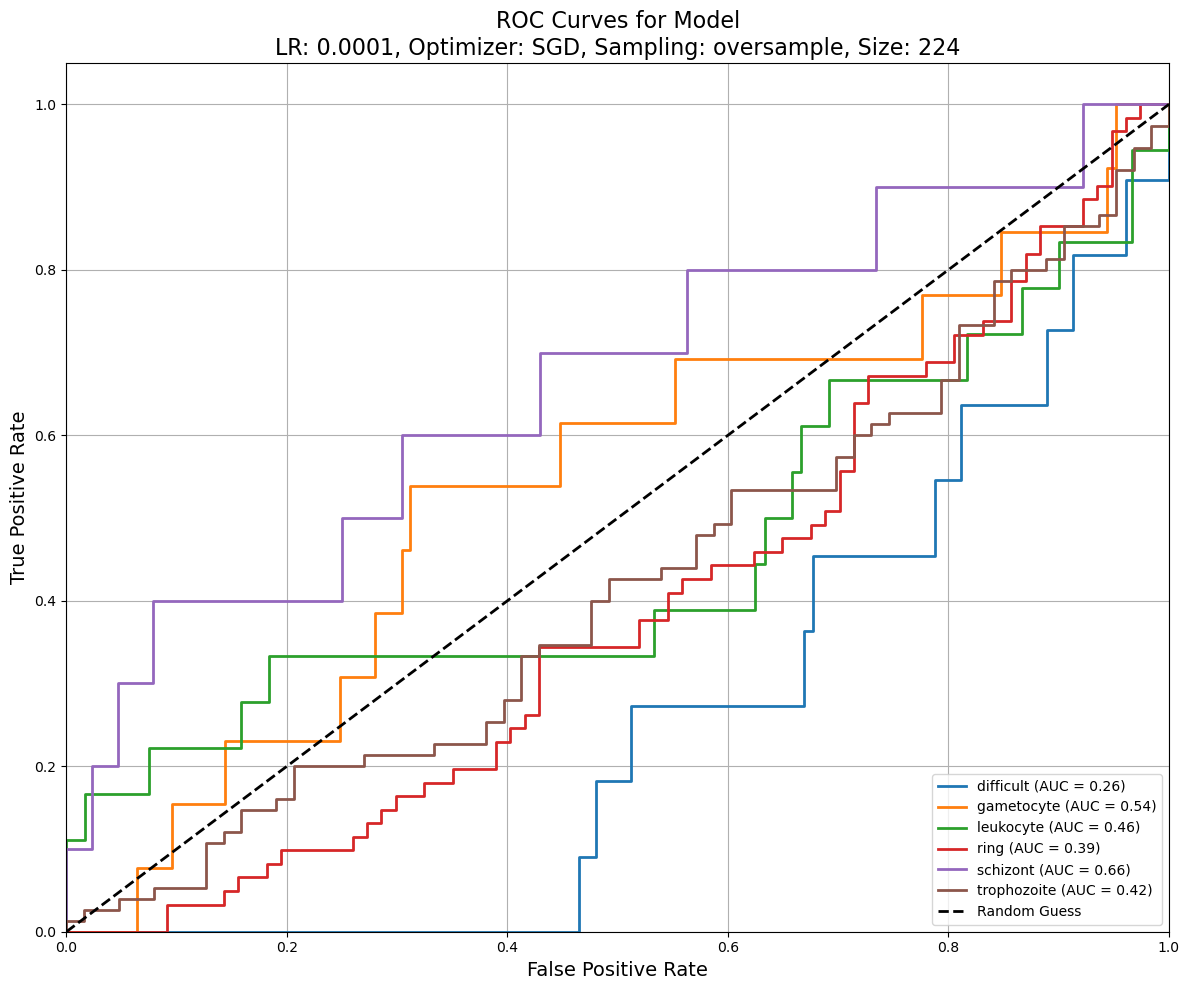

Skipping ROC plot for red blood cell: only one class present.
Macro Average AUC: 0.4549


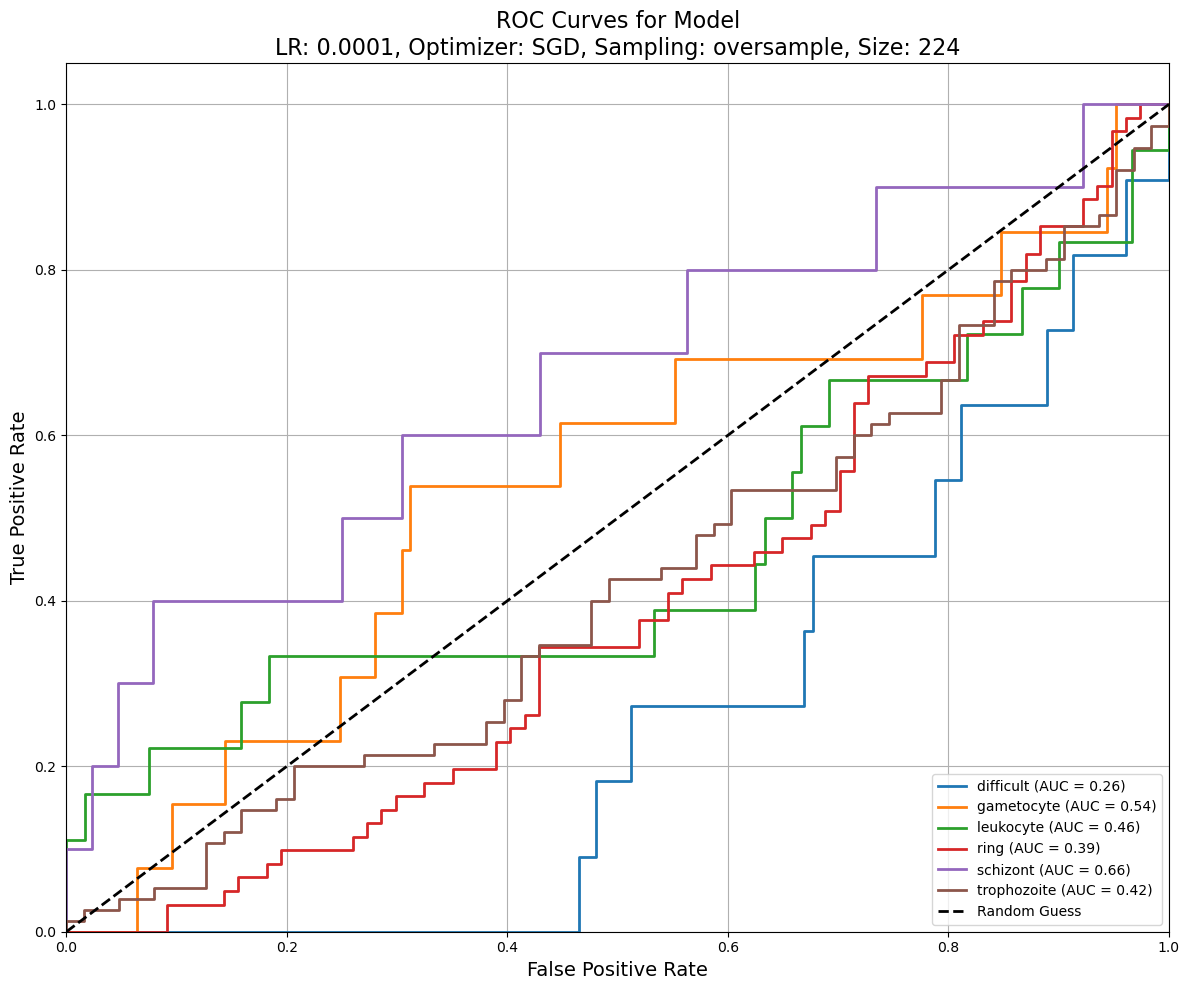

Generating ROC Curves: 100%|██████████| 16/16 [04:38<00:00, 17.42s/it]


In [69]:
roc_results = []

results_filepath = os.path.join(models_dir, "grid_search_results.json")
with open(results_filepath) as f:
    aggregated_results = json.load(f)

# Loop through each model's results
for entry in tqdm(aggregated_results, desc="Generating ROC Curves"):
    params = entry["params"]
    
    # 1. FIX: Dynamically construct the path for the CURRENT model in the loop
    model_filename = (f"model_lr_{params['lr']}_optim_{params['optimizer']}_"
                      f"sampling_{params.get('sampling', 'none')}_size_{params['image_size']}.pth")
    model_path = os.path.join(models_dir, model_filename)

    if not os.path.isfile(model_path):
        continue
        
    # 2. FIX: Initialize a new model instance AND load its unique weights INSIDE the loop
    model = ResNetDetector(num_classes=num_classes).to(device)
    checkpoint = torch.load(model_path, map_location=device) 
    model.load_state_dict(checkpoint["model_state_dict"])
    model.eval()

    # 3. Now, get the scores and plot the curve for this specific model
    test_loader = DataLoader(test_ds, batch_size=params['batch_size'], shuffle=False, collate_fn=detection_collate)
    y_true, y_pred, y_scores = validate_model(model=model,
        val_loader=test_loader,
        device=device,
        image_size=params['image_size'],
        num_classes=num_classes)
    auc_scores = plot_roc_curves(y_true, y_scores, params, class_names)
    
    #   Combine params and scores, and append to our results list  
    if auc_scores: # Only add if scores were calculated
        current_result = {**params, **auc_scores}
        roc_results.append(current_result)
    
    # This will now generate a unique plot for each model
    plot_roc_curves(y_true, y_scores, params, class_names)


In [70]:

#   AFTER THE LOOP: Save the Stored Results to a CSV file  
if roc_results:
    # Convert the list of dictionaries to a Pandas DataFrame
    results_df = pd.DataFrame(roc_results)
    
    # Sort the DataFrame by the macro average AUC to find the best models
    results_df = results_df.sort_values(by='macro_avg_auc', ascending=False)

    # Save the summary to a CSV file for your records
    summary_path = os.path.join(models_dir, "roc_auc_summary.csv")
    results_df.to_csv(summary_path, index=False)
    
    print("\n" + "="*50)
    print("  ROC AUC Summary  ")
    print("="*50)
    print("Displaying best models first:")
    # Display the results table
    print(results_df)
    print(f"\nSummary of ROC AUC scores saved to {summary_path}")
else:
    print("\nNo results were generated to summarize.")


--- ROC AUC Summary ---
Displaying best models first:
        lr optimizer  batch_size    sampling  image_size  difficult  \
9   0.0001      Adam          32        none         224   0.662849   
3   0.0010      Adam          32  oversample         224   0.787402   
12  0.0001       SGD          32        none         128   0.547602   
0   0.0010      Adam          32        none         128   0.738010   
10  0.0001      Adam          32  oversample         128   0.791696   
11  0.0001      Adam          32  oversample         224   0.521117   
6   0.0010       SGD          32  oversample         128   0.600573   
8   0.0001      Adam          32        none         128   0.375089   
4   0.0010       SGD          32        none         128   0.496063   
7   0.0010       SGD          32  oversample         224   0.500000   
5   0.0010       SGD          32        none         224   0.429850   
14  0.0001       SGD          32  oversample         128   0.540444   
15  0.0001       SGD  